# Nelaturi_MahemaReddy_HW4

#### Name: Mahema Reddy Nelaturi 
#### Github Username: mahemareddy
#### USC ID: 2814429305


## 1. Time Series Classification Part 1: Feature Creation/Extraction 

### (a) Download the AReM data

In [1]:
import os
import csv
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import bootstrap
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFECV
from sklearn.utils import resample
import statsmodels.api as sm
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.linear_model import LogisticRegressionCV
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
PATH = '../data/AReM'

### (b) Keep datasets 1 and 2 in folders bending1 and bending 2, as well as datasets 1, 2, and 3 in other folders as test data and other datasets as train data

In [4]:
COLUMNS = ["time", "avg_rss12", "var_rss12", "avg_rss13", "var_rss13", "avg_rss23", "var_rss23"]
ORIGINAL_COLUMNS = ["# Columns: time","avg_rss12","var_rss12","avg_rss13","var_rss13","avg_rss23","var_rss23"]
STATS = ['mean', 'std', 'min', '1st_quartile', 'median', '3rd_quartile', 'max']
ordered_STATS = ['min', 'max', 'mean', 'median', 'std', '1st_quartile', '3rd_quartile']
sniffer = csv.Sniffer()

In [5]:
def split_dataset(path):
    train_files = []
    test_files = []

    for root, dir, file in os.walk(path):
        for f in file:
            if "pdf" not in f:
                fname = os.path.join(root, f)
                if ("bending1" in fname) or ("bending2" in fname):
                    if ("dataset1" in fname) or ("dataset2" in fname):
                        test_files.append(fname)
                    else:
                        train_files.append(fname)
                else:
                    if ("dataset1.csv" in fname) or ("dataset2.csv" in fname) or ("dataset3.csv" in fname):
                        test_files.append(fname)
                    else:
                        if '.DS_Store' not in f:
                            train_files.append(fname)
    return train_files, test_files


In [6]:
train_files, test_files = split_dataset(PATH)
#train_files
# test_files

### (c) Feature Extraction

In [7]:
def get_filename(file):
    path = os.path.dirname(file)
    filename = path.split("\\")
    return filename[-1]

In [8]:
def get_stat_features(stats):
    features = []
    for i in range(1, 7):
        for stat in stats:
            features.append(stat + str(i))
    return features

features = get_stat_features(STATS)
ordered_features = get_stat_features(ordered_STATS)

In [9]:
def get_label(file):
    parent_directory = os.path.dirname(file)
    filename_components = parent_directory.split("/")
    return filename_components[-1]

def get_separator(file):
    f = open(file)
    return sniffer.sniff(f.read()).delimiter

def get_columns(segs=1):
    end = 6 * segs + 1
    feature = []
    for i in range(1, end):
        for stat in STATS:
            feature.append(stat+ str(i))
    return feature

def load_dataset(files, feature, cols, segs=1, standard=False):    
    instances  = []
    labels = []
    for f in files:
        labels.append(get_label(f))
        separator = get_separator(f)
        
        if separator == ",":
            fc = pd.read_csv(f, skiprows=5, header=None, on_bad_lines='skip')
        else:
            fc = pd.read_csv(f, skiprows=5, sep="\\s+", header=None, on_bad_lines='skip')
            
        fc.columns = ORIGINAL_COLUMNS
        
        # breaking time series into equal lengths
        seg_length = int(fc.shape[0] / segs)
        description = []
        for i in range(segs):
            start1 = i * seg_length
            end1 = min((i + 1) * seg_length, fc.shape[0])
            cur_seg = fc[start1 : end1]
            time_col = "# Columns: time"
            cur_describe = cur_seg.describe().drop('count').drop(columns=time_col).T
            description.append(cur_describe.values.flatten())

        instances.append(np.concatenate(description))
            
    # reordering
    feature_df = pd.DataFrame(instances)
    feature_df.columns = get_columns(segs)
    feature_df = feature_df.loc[:, feature]
    
    # label addition
    feature_df['label'] = pd.Series(labels)
    
    return feature_df

In [10]:
train_data = load_dataset(train_files, ordered_features, ORIGINAL_COLUMNS)
train_data

min1   max1      mean1  median1      std1  1st_quartile1  3rd_quartile1  \
0   36.25  48.00  43.969125    44.50  1.618364         43.310          44.67   
1   37.00  48.00  43.454958    43.25  1.386098         42.500          45.00   
2   33.00  47.75  42.179812    43.50  3.670666         39.150          45.00   
3   33.00  45.75  41.678063    41.75  2.243490         41.330          42.75   
4   35.00  47.40  43.954500    44.33  1.558835         43.000          45.00   
..    ...    ...        ...      ...       ...            ...            ...   
64  18.50  44.25  35.752354    36.00  4.614802         33.000          39.33   
65  24.25  45.00  37.177042    36.25  3.581301         34.500          40.25   
66  23.33  43.50  36.248768    36.75  3.824632         33.415          39.25   
67  26.25  44.25  36.957458    36.29  3.434863         34.500          40.25   
68  27.75  44.67  37.142359    36.33  3.762442         34.000          40.50   

    min2   max2     mean2  ...  1st_quartile5  3rd_quartile5  min6   max6  \
0    0.0   1.50  0.413125  ...        20.5000        23.7500   0.0   2.96   
1    0.0   1.58  0.378083  ...        22.2500        24.0000   0.0   5.26   
2    0.0   3.00  0.696042  ...        30.4575        36.3300   0.0   2.18   
3    0.0   2.83  0.535979  ...        28.4575        31.2500   0.0   1.79   
4    0.0   1.70  0.426250  ...        35.3625        36.5000   0.0   1.79   
..   ...    ...       ...  ...            ...            ...   ...    ...   
64   0.0  12.60  3.328104  ...        14.0000        18.0625   0.0   9.39   
65   0.0   8.58  2.374208  ...        17.9500        21.7500   0.0   9.34   
66   0.0   9.71  2.737307  ...        15.7500        21.0000   0.0  11.15   
67   0.0   8.64  2.420083  ...        14.0000        18.2500   0.0   8.34   
68   0.0  10.76  2.422150  ...        15.0000        18.7500   0.0   8.75   

       mean6  median6      std6  1st_quartile6  3rd_quartile6     label  
0   0.555312    0.490  0.487826         0.0000          0.830  bending1  
1   0.679646    0.500  0.622534         0.4300          0.870  bending1  
2   0.613521    0.500  0.524317         0.0000          1.000  bending1  
3   0.383292    0.430  0.389164         0.0000          0.500  bending1  
4   0.493292    0.430  0.513506         0.0000          0.940  bending1  
..       ...      ...       ...            ...            ...       ...  
64  3.069667    2.770  1.748326         1.7975          4.060   cycling  
65  2.921729    2.500  1.852600         1.5000          3.900   cycling  
66  3.532463    3.110  1.965267         2.1700          4.625   cycling  
67  2.934625    2.525  1.631380         1.6600          4.030   cycling  
68  2.825720    2.590  1.637312         1.5900          3.740   cycling  

[69 rows x 43 columns]

In [11]:
test_data = load_dataset(test_files, ordered_features, ORIGINAL_COLUMNS)
test_data

min1   max1      mean1  median1      std1  1st_quartile1  3rd_quartile1  \
0   37.25  45.00  40.624792   40.500  1.476967        39.2500        42.0000   
1   38.00  45.67  42.812812   42.500  1.435550        42.0000        43.6700   
2   19.33  43.50  34.227771   35.500  4.889576        30.5000        37.7500   
3   12.50  45.00  33.509729   34.125  4.850923        30.5000        36.7500   
4   15.00  46.75  34.660583   35.000  5.315110        31.0000        38.2500   
5   12.75  51.00  24.562958   24.250  3.737514        23.1875        26.5000   
6    0.00  42.75  27.464604   28.000  3.583582        25.5000        30.0000   
7   33.33  48.00  44.334729   45.000  2.476940        42.2500        46.5000   
8   35.50  46.25  43.174938   43.670  1.989052        42.5000        44.5000   
9   32.75  47.00  42.760562   44.500  3.398919        41.3300        45.3725   
10  33.25  48.00  42.363563   43.000  2.068247        42.0000        43.5000   
11  37.00  50.75  45.917667   45.635  1.089027        45.0000        46.5000   
12  44.50  46.75  45.239667   45.000  0.429915        45.0000        45.3300   
13  23.50  30.00  27.716375   27.500  1.442253        27.0000        29.0000   
14  24.75  48.33  44.182937   48.000  7.495615        48.0000        48.0000   
15  48.00  48.25  48.004167   48.000  0.032038        48.0000        48.0000   
16  24.25  45.00  37.177042   36.250  3.581301        34.5000        40.2500   
17  28.75  44.75  37.561187   36.875  3.226507        35.2500        40.2500   
18  22.00  44.67  37.058708   36.000  3.710180        34.5000        40.0625   

    min2   max2     mean2  ...  1st_quartile5  3rd_quartile5  min6  max6  \
0    0.0   1.30  0.358604  ...        33.0000        36.0000   0.0  1.92   
1    0.0   1.22  0.372437  ...        32.0000        34.5000   0.0  3.11   
2    0.0  14.50  3.995729  ...        14.7500        18.6700   0.0  9.74   
3    0.0  13.05  4.450771  ...        14.6275        18.7500   0.0  8.96   
4    0.0  13.44  4.200896  ...        14.2500        18.5000   0.0  8.99   
5    0.0   6.87  0.590833  ...        20.5000        27.0000   0.0  4.97   
6    0.0   7.76  0.449708  ...        15.0000        20.7500   0.0  6.76   
7    0.0   3.90  0.432958  ...         9.3300        17.7500   0.0  5.02   
8    0.0   2.12  0.506583  ...        12.7500        16.5000   0.0  5.72   
9    0.0   3.34  0.486167  ...        13.0000        18.5650   0.0  5.73   
10   0.0   4.44  0.492563  ...        10.1875        17.6900   0.0  6.02   
11   0.0   4.87  0.324542  ...        16.5000        21.0000   0.0  7.22   
12   0.0   1.00  0.172958  ...        17.6275        21.0000   0.0  8.20   
13   0.0   1.79  0.363687  ...         5.5000        10.7500   0.0  4.50   
14   0.0   3.11  0.101875  ...         2.0000         5.5425   0.0  3.91   
15   0.0   0.43  0.007167  ...         4.6700        10.0000   0.0  2.50   
16   0.0   8.58  2.374208  ...        17.9500        21.7500   0.0  9.34   
17   0.0   9.91  2.080687  ...        18.0000        21.5000   0.0  9.62   
18   0.0  14.17  2.438146  ...        16.0000        21.0000   0.0  8.55   

       mean6  median6      std6  1st_quartile6  3rd_quartile6     label  
0   0.570583    0.430  0.582915         0.0000          1.300  bending1  
1   0.571083    0.430  0.601010         0.0000          1.300  bending1  
2   3.394125    3.100  1.792090         2.1050          4.425   walking  
3   3.378479    3.085  1.787360         2.0600          4.440   walking  
4   3.244396    3.000  1.630983         2.1200          4.240   walking  
5   0.700188    0.500  0.693720         0.4300          0.870  bending2  
6   1.122125    0.830  1.012342         0.4700          1.300  bending2  
7   0.933000    0.830  0.673609         0.4700          1.250  standing  
8   0.911979    0.830  0.666161         0.4700          1.220  standing  
9   0.842271    0.710  0.722165         0.4300          1.090  standing  
10  1.034021    0.830  0.985627         0.4700          1.250   sitti

In [12]:
train_data.describe().loc['std']

min1             8.794295
max1             4.429182
mean1            4.917692
median1          4.956111
std1             1.758670
1st_quartile1    5.731647
3rd_quartile1    4.783645
min2             0.000000
max2             5.147841
mean2            1.600701
median2          1.436960
std2             0.902808
1st_quartile2    0.952201
3rd_quartile2    2.158416
min3             3.053869
max3             4.759853
mean3            3.863097
median3          3.845730
std3             0.995959
1st_quartile3    4.145255
3rd_quartile3    3.946023
min4             0.000000
max4             2.302408
mean4            1.179861
median4          1.150092
std4             0.473576
1st_quartile4    0.842501
3rd_quartile4    1.566564
min5             5.368786
max5             5.449726
mean5            5.120426
median5          5.267414
std5             1.057998
1st_quartile5    5.543882
3rd_quartile5    4.957231
min6             0.051766
max6             2.540166
mean6            1.171401
median6     

In [13]:
test_data.describe().loc['std']

min1             12.136206
max1              4.379342
mean1             6.790086
median1           7.088085
std1              1.869285
1st_quartile1     7.673052
3rd_quartile1     6.385720
min2              0.000000
max2              4.870395
mean2             1.500529
median2           1.345903
std2              0.832472
1st_quartile2     0.941307
3rd_quartile2     2.028482
min3              2.644618
max3              5.393220
mean3             4.588252
median3           4.753522
std3              0.760779
1st_quartile3     4.554121
3rd_quartile3     5.014339
min4              0.000000
max4              1.733937
mean4             1.146338
median4           1.161705
std4              0.409008
1st_quartile4     0.867088
3rd_quartile4     1.541943
min5              8.252947
max5              6.782153
mean5             7.366781
median5           7.438749
std5              0.919274
1st_quartile5     7.823870
3rd_quartile5     7.259433
min6              0.000000
max6              2.505306
m

In [14]:
data_CI = train_data.iloc[:, :-1]
col = list(data_CI.columns)

lows = []
highs = []
for i in col:
    data = (data_CI[i],)
    bootstrap_CI = bootstrap(data, np.std, confidence_level=0.9, random_state= 1, method='basic')
    lows.append(bootstrap_CI.confidence_interval[0])
    highs.append(bootstrap_CI.confidence_interval[1])
CI_table = pd.DataFrame(columns = ['Low_Confidence', 'High_Confidence'])
CI_table['Low_Confidence'] = lows
CI_table['High_Confidence'] = highs

CI_table.index = col
CI_table

Low_Confidence  High_Confidence
min1                 7.502012         9.989366
max1                 3.450496         5.536179
mean1                4.377907         5.479814
median1              4.396912         5.542160
std1                 1.559253         1.960701
1st_quartile1        5.204934         6.270986
3rd_quartile1        4.005674         5.619483
min2                 0.000000         0.000000
max2                 4.735969         5.602172
mean2                1.451224         1.786358
median2              1.286878         1.621620
std2                 0.835032         0.986904
1st_quartile2        0.850285         1.075838
3rd_quartile2        1.966383         2.396305
min3                 2.868509         3.257571
max3                 4.110230         5.489979
mean3                3.301070         4.494771
median3              3.251628         4.507301
std3                 0.786335         1.206897
1st_quartile3        3.584310         4.774053
3rd_quartile3        3.351926         4.615529
min4                 0.000000         0.000000
max4                 2.090837         2.516093
mean4                1.112766         1.271258
median4              1.083014         1.241790
std4                 0.438902         0.513291
1st_quartile4        0.784917         0.912590
3rd_quartile4        1.476816         1.688894
min5                 3.855023         7.136732
max5                 4.465269         6.546641
mean5                3.897320         6.473533
median5              3.974131         6.691782
std5                 0.826282         1.308102
1st_quartile5        4.273857         6.939634
3rd_quartile5        3.798461         6.212776
min6                 0.015088         0.102779
max6                 2.238468         2.834062
mean6                1.099027         1.266044
median6              1.032117         1.197654
std6                 0.485847         0.557791
1st_quartile6        0.717473         0.845018
3rd_quartile6        1.457491         1.675656

## 2. Time Series Classification Part 2: Binary and Multiclass Classification

### (a) Binary Classification Using Logistic Regression


#### i. Depict scatter plots of the features you specified in 1(c)iv extracted from time series 1, 2, and 6 of each instance, and use color to distinguish bending vs. other activities.

In [15]:
def get_cols(indexes, props):
    cols = []
    for index in indexes:
        for prop in props:
            col_name = prop + str(index)
            cols.append(col_name)
    return cols

def get_labelled_cols(df, cols):
    temp = df['label']
    df.loc[temp.isin(['bending1', 'bending2']), 'label'] = 1
    df.loc[temp != 1, 'label'] = 0
    return cols + ['label']

def plot_scatter_plot(df, hue_value):
    sns.pairplot(df, hue=hue_value)
    plt.show()

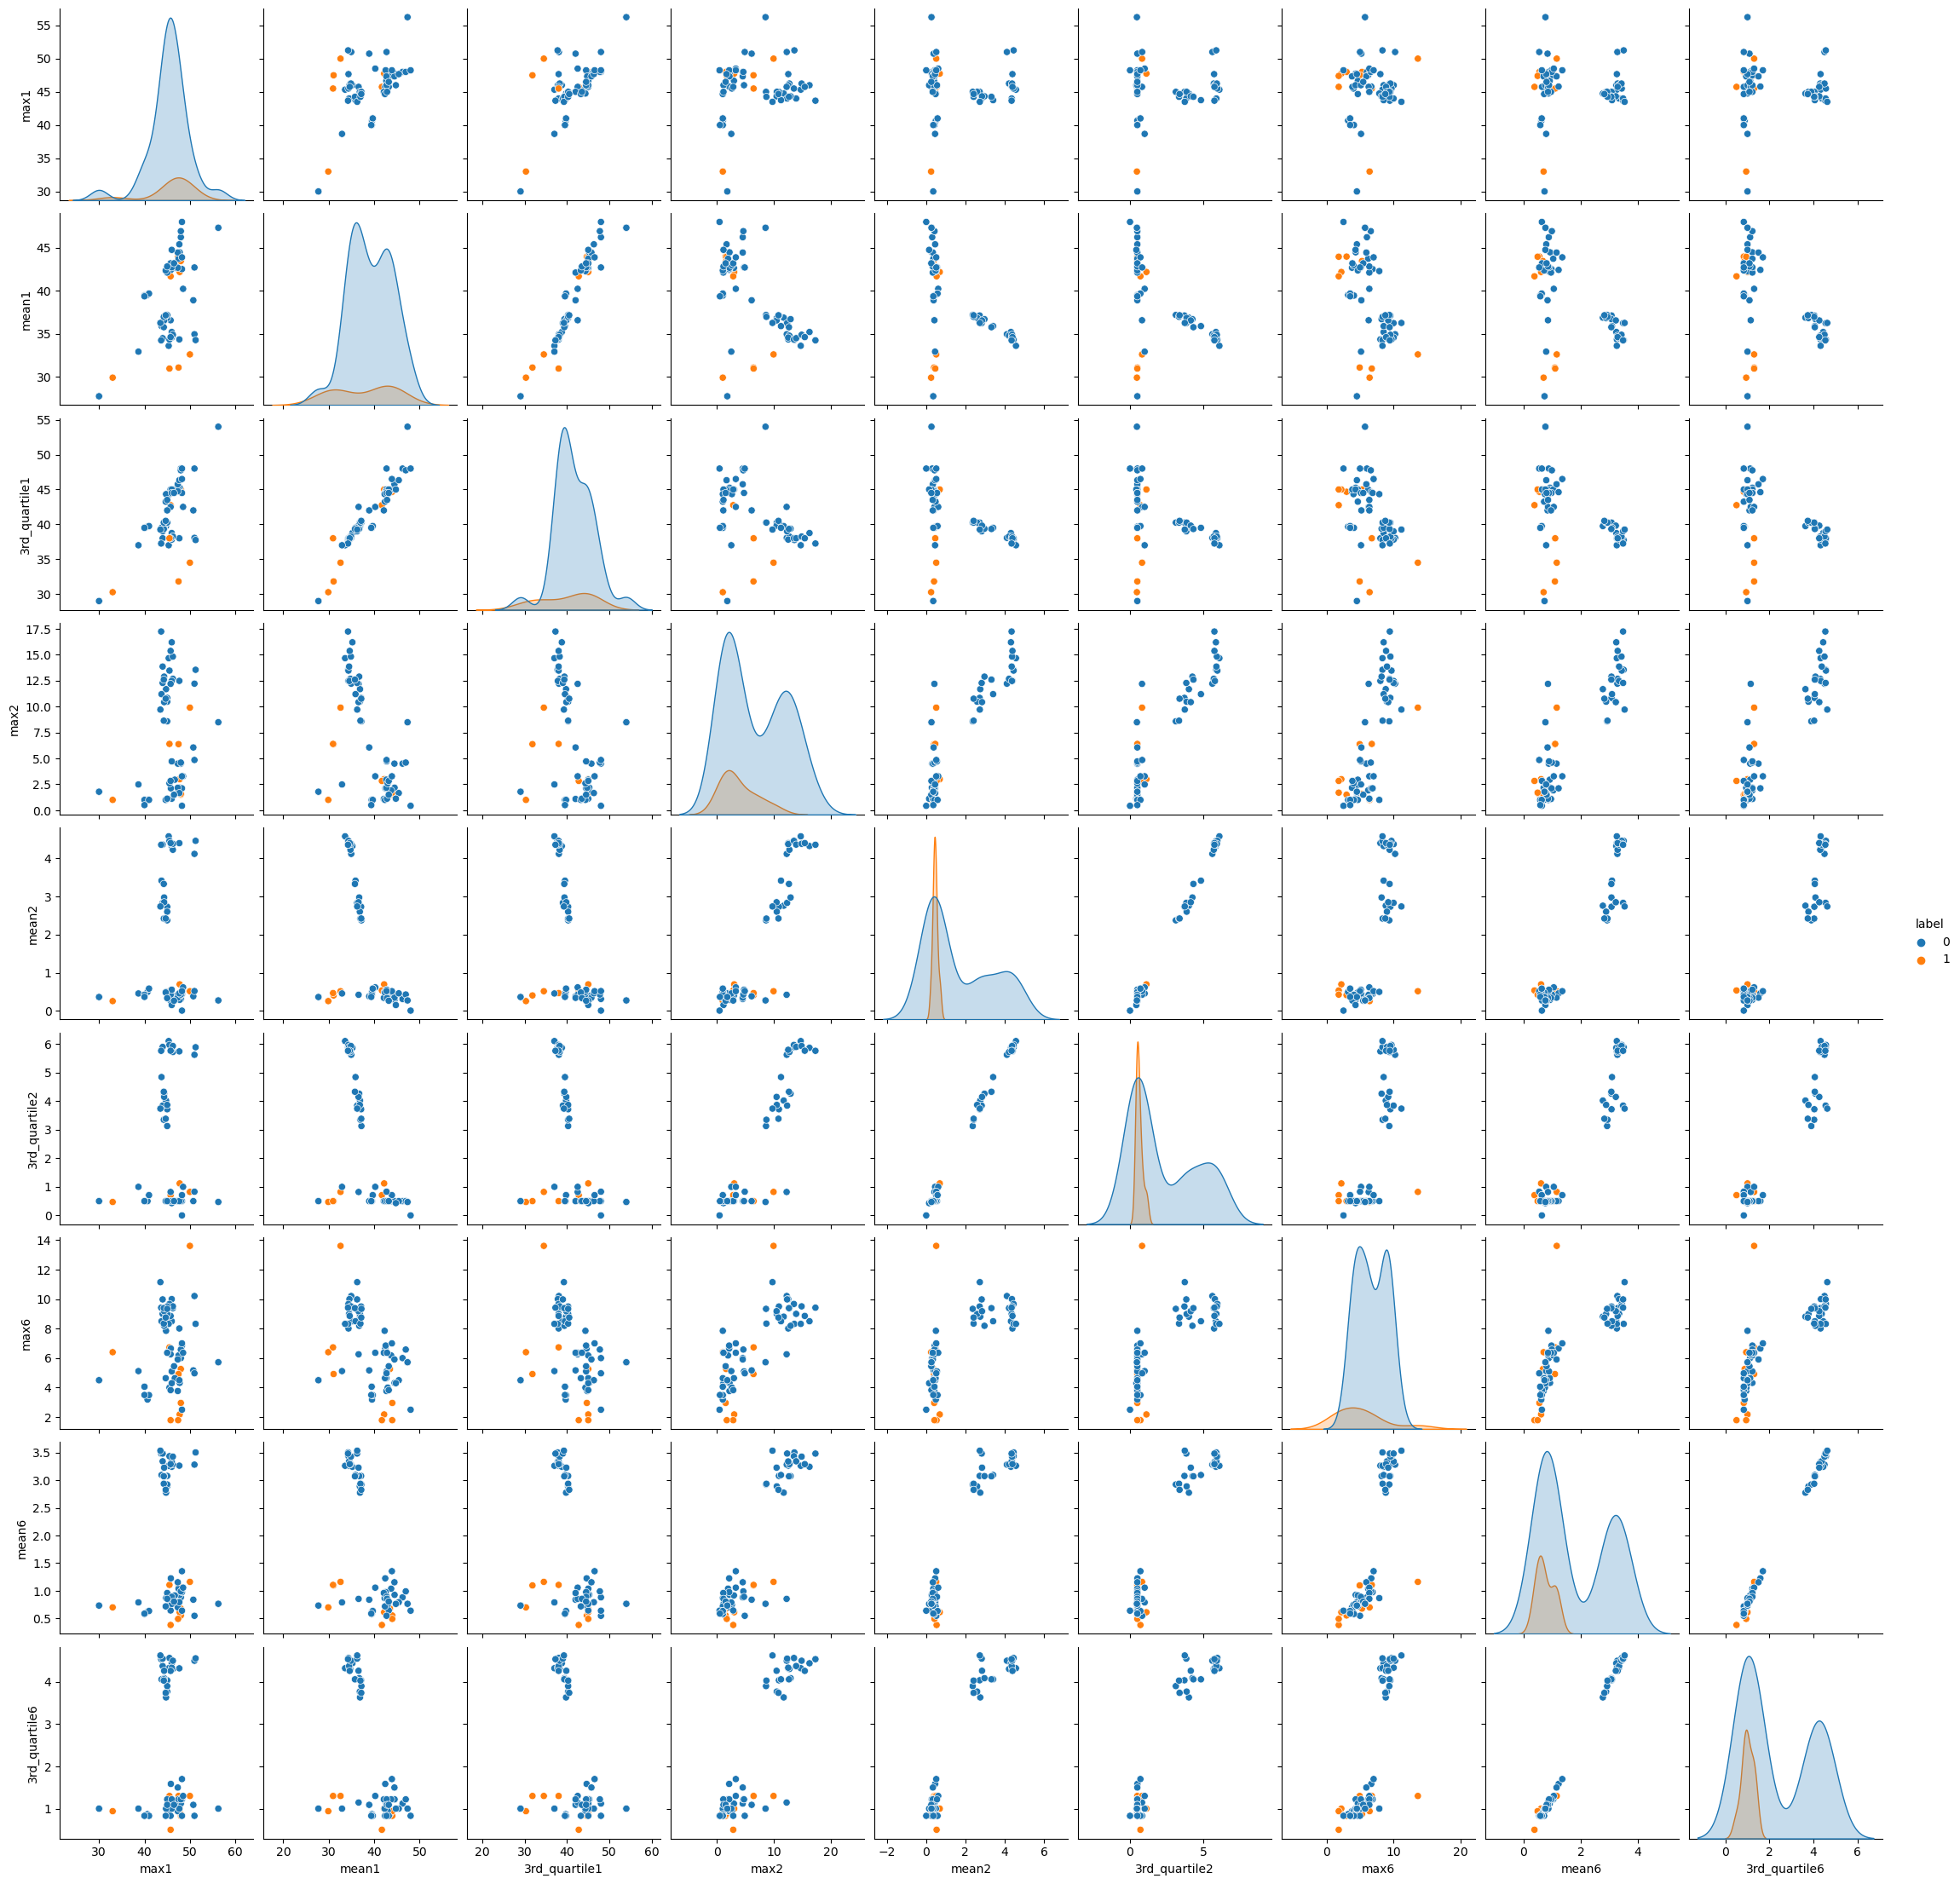

In [16]:
relevant_columns = get_cols([1, 2, 6], ['max', 'mean', '3rd_quartile'])
relevant_columns_labelled = get_labelled_cols(train_data, relevant_columns)
relevant_df = train_data[relevant_columns_labelled]
plot_scatter_plot(relevant_df, 'label')

#### ii. Repeat the experiment in 2(a)i, i.e depict scatter plots of the features extracted from both parts of the time series 1,2, and 6. Do you see any considerable difference in the results with those of 2(a)i?

In [17]:
def get_binary_labelled_dataframe(df):
    temp = df['label']
    df.loc[temp.isin(['bending1', 'bending2']), 'label'] = 1
    df.loc[temp != 1, 'label'] = 0
    return df

features = []
for i in range(1, 13):
    for stat in ordered_STATS:
        col_name = stat + str(i)
        features.append(col_name)

train_data_two = load_dataset(train_files, features, ORIGINAL_COLUMNS, segs=2)
test_data_two = load_dataset(test_files, features, ORIGINAL_COLUMNS, segs=2)

In [18]:
train_df_two = get_binary_labelled_dataframe(pd.DataFrame(train_data_two))
train_df_two

min1   max1      mean1  median1      std1  1st_quartile1  3rd_quartile1  \
0   36.67  45.00  43.486208    43.71  1.281976        42.3300          44.50   
1   39.00  48.00  44.117042    45.00  1.359836        43.5000          45.00   
2   33.75  47.75  43.278875    45.00  3.473355        42.0000          45.25   
3   33.00  45.75  41.621208    42.33  3.118644        39.6525          44.25   
4   36.50  46.50  44.057167    44.50  1.556971        43.2500          45.00   
..    ...    ...        ...      ...       ...            ...            ...   
64  20.00  44.25  35.692167    35.50  4.643595        33.0000          39.25   
65  24.25  45.00  36.954208    36.00  3.772836        34.2500          40.25   
66  27.00  42.67  36.337908    36.75  3.655379        33.6700          39.00   
67  26.25  43.40  36.865417    36.25  3.462793        34.3100          40.00   
68  27.75  44.00  37.132636    36.67  3.808255        34.0000          40.33   

    min2   max2     mean2  ...  1st_quartile11  3rd_quartile11  min12  max12  \
0    0.0   1.30  0.378667  ...          21.000         23.5000    0.0   2.96   
1    0.0   1.30  0.250042  ...          22.500         23.7500    0.0   4.06   
2    0.0   3.00  0.673292  ...          28.750         33.7500    0.0   2.18   
3    0.0   2.83  0.623083  ...          28.310         30.5625    0.0   1.50   
4    0.0   1.50  0.381042  ...          33.000         36.2500    0.0   1.50   
..   ...    ...       ...  ...             ...             ...    ...    ...   
64   0.0  11.39  3.324208  ...          14.000         18.2500    0.0   8.81   
65   0.0   8.18  2.392667  ...          18.000         21.6700    0.0   9.34   
66   0.0   9.71  2.698494  ...          16.125         21.0000    0.0  11.15   
67   0.0   7.46  2.387250  ...          14.330         18.0000    0.0   8.34   
68   0.0  10.76  2.388870  ...          15.000         18.7500    0.0   7.93   

      mean12  median12     std12  1st_quartile12  3rd_quartile12  label  
0   0.585750      0.50  0.487918          0.4225          0.8300      1  
1   0.543875      0.50  0.473445          0.4300          0.7100      1  
2   0.586083      0.47  0.491873          0.0000          0.8700      1  
3   0.347500      0.43  0.363144          0.0000          0.5000      1  
4   0.388333      0.00  0.478528          0.0000          0.7100      1  
..       ...       ...       ...             ...             ...    ...  
64  2.966917      2.59  1.712062          1.8525          3.7400      0  
65  2.838083      2.45  1.890755          1.3825          3.8325      0  
66  3.530669      3.08  1.998170          2.1700          4.5150      0  
67  2.904458      2.57  1.609793          1.6900          3.7700      0  
68  2.727866      2.55  1.588045          1.5000          3.7000      0  

[69 rows x 85 columns]

In [19]:
test_df_two = get_binary_labelled_dataframe(pd.DataFrame(test_data_two))
test_df_two

min1   max1      mean1  median1      std1  1st_quartile1  3rd_quartile1  \
0   38.00  42.33  40.946958   41.250  1.102963        40.3100        42.0000   
1   41.75  44.25  42.643292   42.500  0.641849        42.0000        43.3300   
2   22.33  42.50  34.334833   35.750  4.772089        30.4750        37.7500   
3   18.67  45.00  33.762958   34.500  5.001292        30.7500        37.3125   
4   15.00  45.33  33.591625   34.250  5.121057        30.0000        37.0000   
5   12.75  51.00  24.675375   24.330  4.856867        22.2500        26.7500   
6   26.50  31.33  29.071583   29.500  1.133954        28.2500        30.0000   
7   38.50  48.00  46.127875   46.500  1.151699        45.5000        46.7500   
8   35.50  45.00  43.043292   43.500  1.874343        42.5000        44.5000   
9   37.00  46.50  44.447083   45.000  1.667042        44.1875        45.5000   
10  40.50  44.00  42.681292   42.585  0.803629        42.0000        43.5000   
11  37.00  50.75  45.811458   45.000  1.421195        45.0000        46.5000   
12  45.00  46.75  45.409875   45.250  0.529789        45.0000        45.7500   
13  23.50  29.75  27.368417   27.000  1.295725        27.0000        28.7500   
14  24.75  48.25  40.361042   48.000  9.125029        29.5000        48.0000   
15  48.00  48.25  48.001042   48.000  0.016137        48.0000        48.0000   
16  24.25  45.00  36.954208   36.000  3.772836        34.2500        40.2500   
17  29.25  44.75  37.592250   37.000  3.127179        35.2500        39.7500   
18  28.00  44.67  37.740667   36.710  3.536378        35.2500        40.7500   

    min2   max2     mean2  ...  1st_quartile11  3rd_quartile11  min12  max12  \
0   0.00   1.22  0.375667  ...         31.3100         36.5000    0.0   1.92   
1   0.00   0.94  0.355000  ...         30.0000         33.7500    0.0   3.11   
2   0.00  12.19  3.974958  ...         14.7500         18.5000    0.0   8.86   
3   0.43  13.05  4.400833  ...         14.7300         18.8125    0.0   8.96   
4   0.00  12.53  4.573042  ...         14.1875         18.5000    0.0   8.26   
5   0.00   6.87  0.774500  ...         19.4575         21.7500    0.0   4.97   
6   0.00   1.25  0.231208  ...         12.3300         20.7625    0.0   6.76   
7   0.00   1.79  0.424542  ...          7.0000         12.0000    0.0   3.77   
8   0.00   2.12  0.500667  ...         13.6700         17.0000    0.0   4.64   
9   0.00   1.73  0.410458  ...         11.7500         18.8125    0.0   5.73   
10  0.00   1.12  0.365875  ...         14.5000         18.7500    0.0   5.85   
11  0.00   4.87  0.204167  ...         17.0000         20.7500    0.0   7.22   
12  0.00   1.00  0.260750  ...         17.7500         21.0000    0.0   3.49   
13  0.00   1.79  0.308042  ...          3.3300         10.0000    0.0   3.30   
14  0.00   3.11  0.194583  ...          1.5000          2.5000    0.0   3.77   
15  0.00   0.43  0.001792  ...          9.5000         10.7500    0.0   1.30   
16  0.00   8.18  2.392667  ...         18.0000         21.6700    0.0   9.34   
17  0.00   8.95  2.111625  ...         18.2500         21.5425    0.0   9.62   
18  0.00  12.99  2.147167  ...         14.1875         19.3125    0.0   8.55   

      mean12  median12     std12  1st_quartile12  3rd_quartile12  label  
0   0.552167     0.430  0.510494          0.0000          0.9400      1  
1   0.533583     0.430  0.575061          0.0000          0.8700      1  
2   3.400750     3.080  1.804246          2.0600          4.5000      0  
3   3.378250     3.110  1.803453          2.0575          4.4550      0  
4   3.206833     2.980  1.710663          1.9800          4.2450      0  
5   0.936917     0.810  0.818833          0.4700          1.0975      1  
6   1.473250     1.220  1.238675          0.5000          1.9525      1  
7   0.870042     0.820  0.678663          0.4600          1.1450      0  
8   0.874750     0.830  0.635470          0.4700          1.1700      0  
9   0.906500     0.830  0.741206          0.4300          1.220

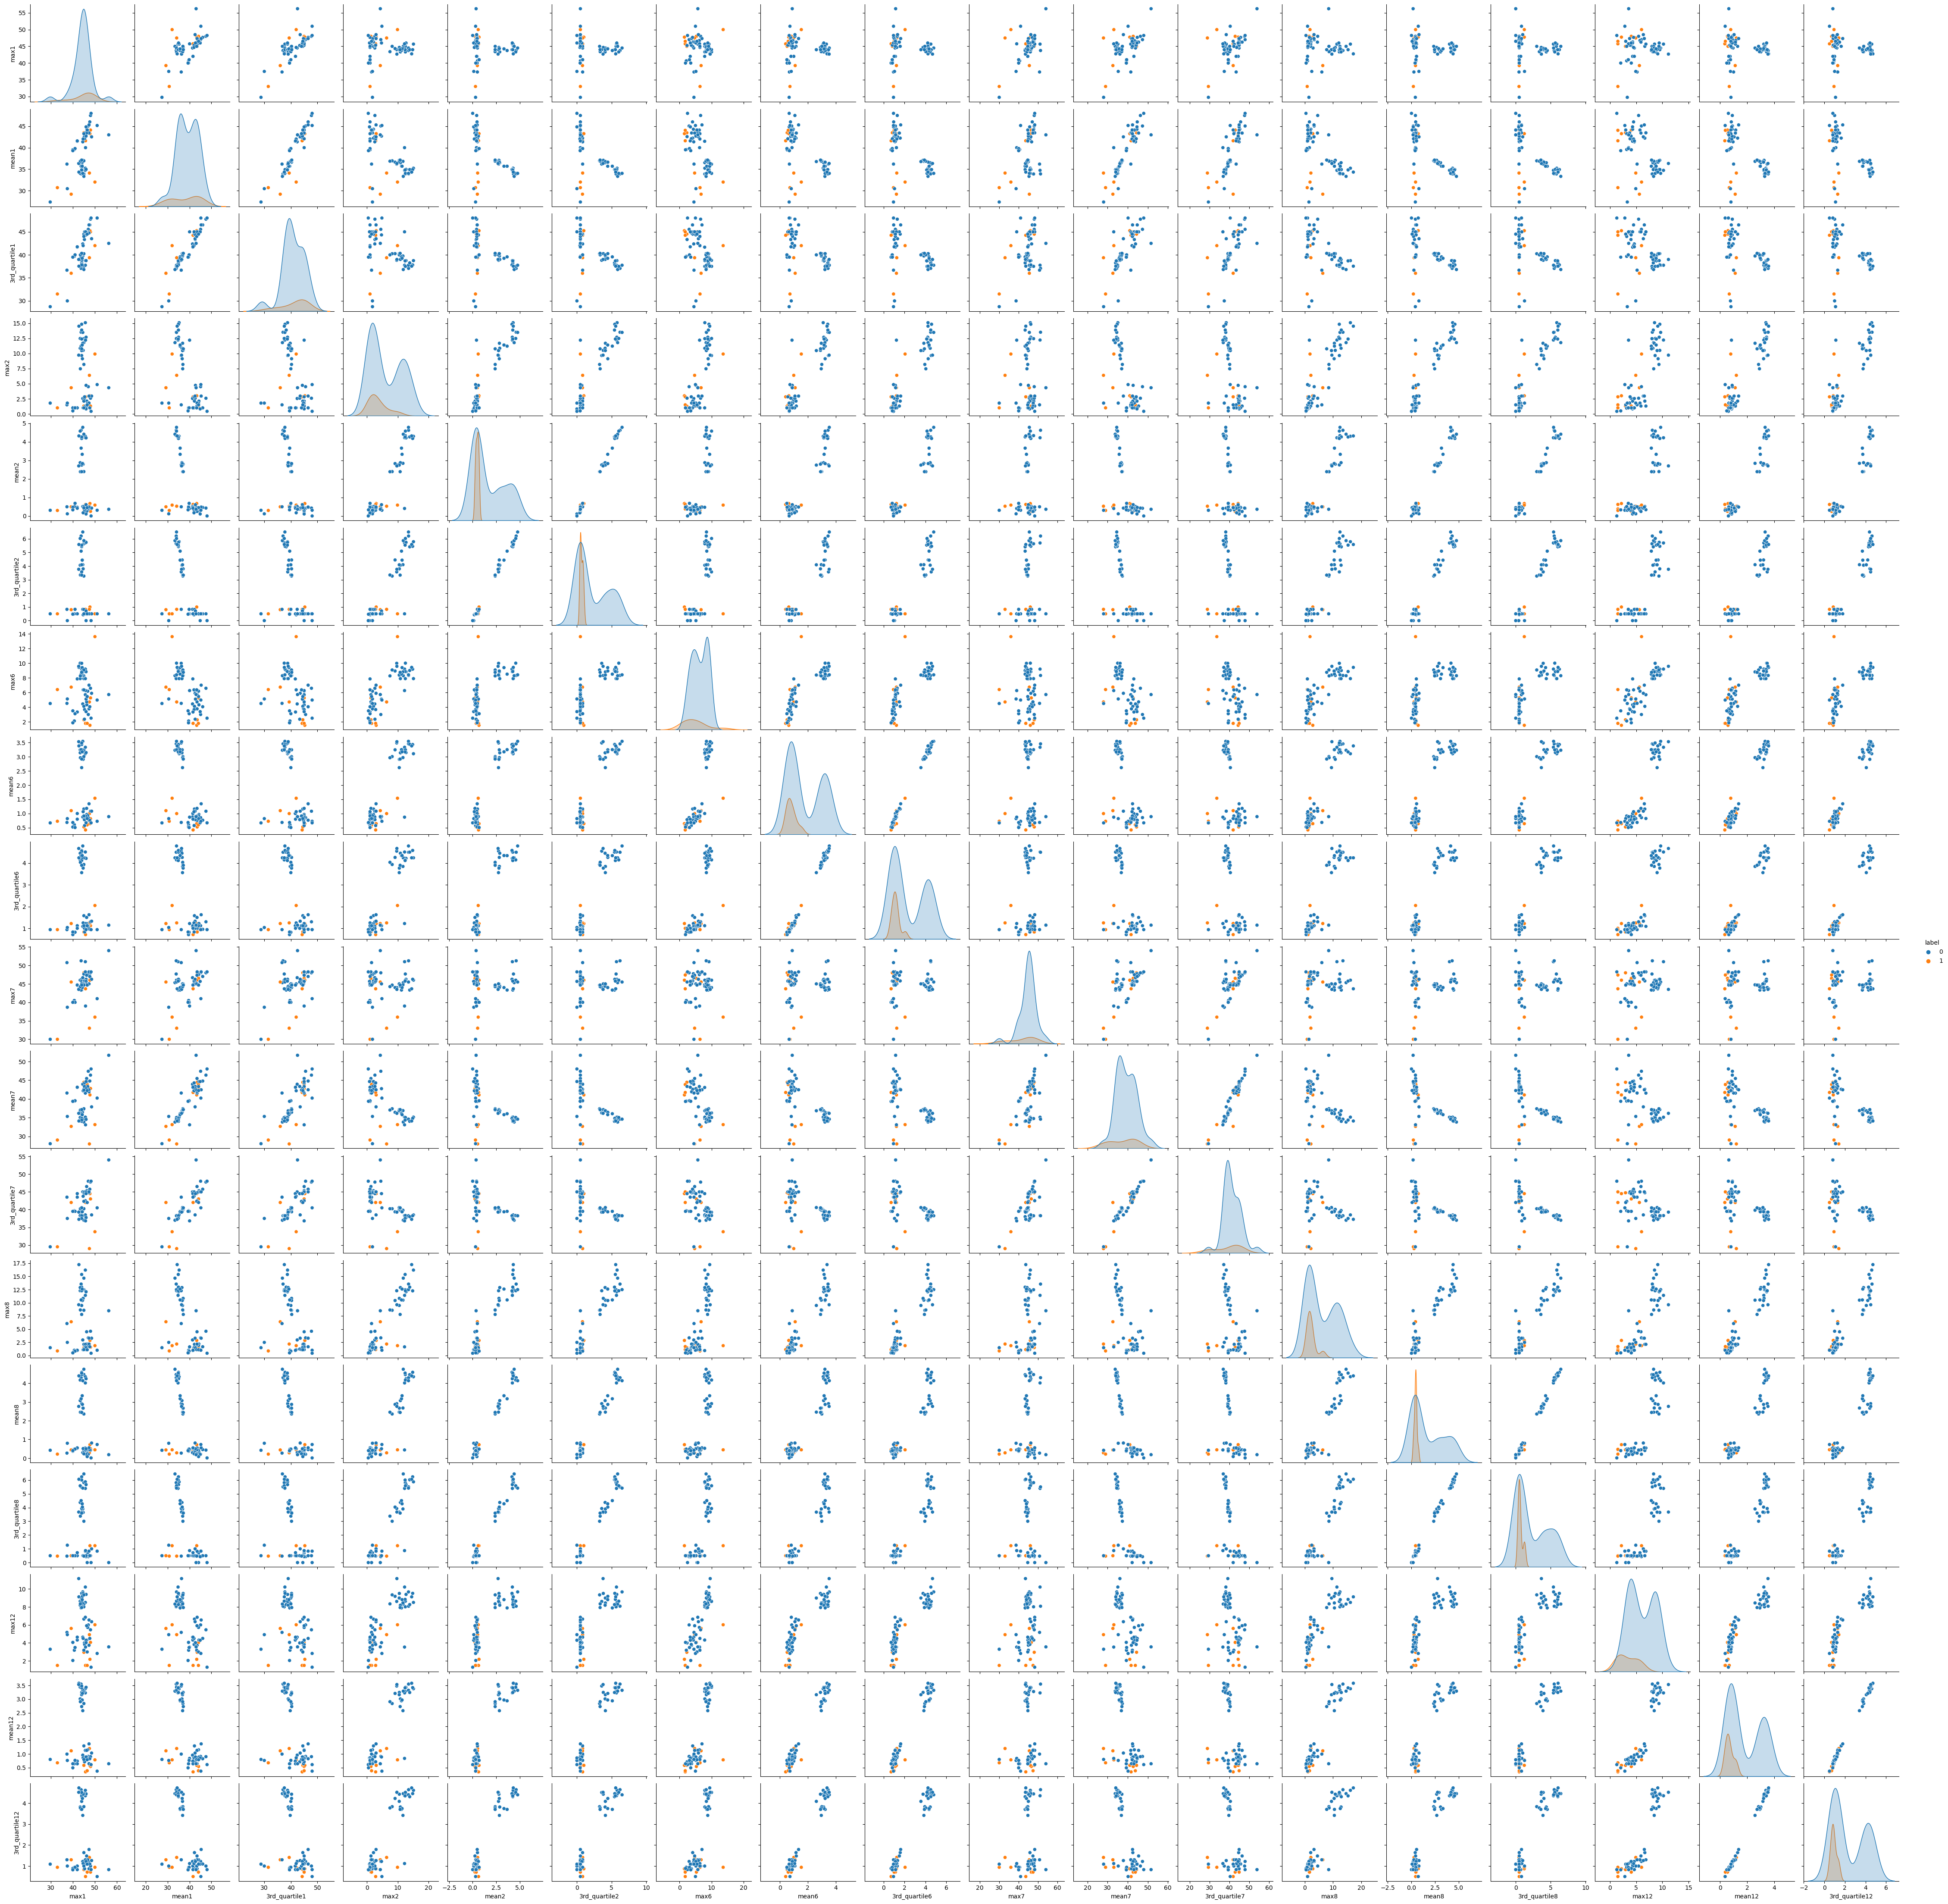

In [20]:
relevant_columns_two = get_cols([1, 2, 6, 7, 8, 12], ['max', 'mean', '3rd_quartile'])
relevant_columns_labelled_two = get_labelled_cols(train_data, relevant_columns_two)
relevant_df_two = train_data_two[relevant_columns_labelled_two]
plot_scatter_plot(relevant_df_two, 'label')

### There does not seem to be any significant difference between the two.

### iii. Time Series Segments

In [21]:
def get_features(stats, range_end):
    features = []
    for i in range(1, range_end):
        for stat in stats:
            features.append(f'{stat}{i}')
    return features

def oversample_data_set(data_set):
    print('Performing oversampling of dataset...')
    label_0 = data_set.loc[data_set['label'] == "0"].shape[0]
    label_1 = data_set.loc[data_set['label'] == "1"].shape[0]
    minor_count = min(label_0, label_1)
    major_count = max(label_0, label_1)
    
    if label_0 > label_1:
        minor_label = "1"
        major_label = "0"
    else:
        minor_label = "0"
        major_label = "1"
        
    minor_ds = data_set[data_set['label'] == minor_label]
    major_ds = data_set[data_set['label'] == major_label]
    minor_ds = resample(minor_ds, replace=True, random_state=60, n_samples=max(label_0, label_1))
    data_set = pd.concat([major_ds, minor_ds])
    return data_set


def convert_text_labels_to_boolean(df):
    temp = df['label']
    df.loc[temp.isin(['bending1', 'bending2']), 'label'] = "1"
    df.loc[temp != "1", 'label'] = "0"
    return df

def get_data_X_Y(data_set):
    dataX = data_set.iloc[:, :-1]
    dataY = data_set.iloc[:, -1]
    return dataX, dataY

def logistic_regression(train_files, test_files, l_val, fold_count, oversample=False, penalty='none'):
    print("L-value: ", l_val)
    features = get_features(ordered_STATS, 6 * l_val + 1)
    train_set = load_dataset(train_files, features, ORIGINAL_COLUMNS, segs=l_val)
    train_set = convert_text_labels_to_boolean(pd.DataFrame(train_set))
    
    if oversample:
        train_set = oversample_data_set(train_set)
    
    trainX, trainY = get_data_X_Y(train_set)
    
    solver = 'liblinear' if penalty == 'l1' else 'lbfgs'
    validator = StratifiedKFold(n_splits=fold_count, shuffle=True, random_state=69)
    model = LogisticRegression(penalty=penalty, solver=solver, max_iter=100)
    selector = RFECV(estimator=model, cv=validator, scoring='accuracy')
    selector.fit(trainX, trainY)
    return model, selector

In [22]:
cross_validation_factor = 5
L = 20
combination = {
    'pair(l, p)': [],
    'score': []
}
for l_val in range(1, L + 1):
    model, selector = logistic_regression(train_files, test_files, l_val, cross_validation_factor, oversample=False)
    nf = selector.n_features_
    score = selector.cv_results_['mean_test_score'].max()
    combination['pair(l, p)'].append((l_val, nf))
    combination['score'].append(round(score, 4))

df = pd.DataFrame(combination)
df

L-value:  1
L-value:  2
L-value:  3
L-value:  4
L-value:  5
L-value:  6
L-value:  7
L-value:  8
L-value:  9
L-value:  10
L-value:  11
L-value:  12
L-value:  13
L-value:  14
L-value:  15
L-value:  16
L-value:  17
L-value:  18
L-value:  19
L-value:  20


pair(l, p)   score
0      (1, 6)  1.0000
1      (2, 5)  0.9429
2      (3, 7)  0.9857
3      (4, 9)  0.9714
4      (5, 3)  0.9857
5     (6, 36)  0.9857
6     (7, 16)  0.9714
7     (8, 31)  0.9714
8     (9, 43)  0.9857
9    (10, 47)  0.9714
10    (11, 9)  0.9857
11   (12, 85)  0.9857
12   (13, 12)  0.9857
13   (14, 15)  0.9714
14   (15, 37)  0.9857
15   (16, 12)  0.9857
16   (17, 11)  0.9857
17    (18, 9)  0.9857
18   (19, 10)  0.9857
19   (20, 11)  0.9857

- The purpose of cross-validation is to estimate the error on test data. We do not want to deprive our algorithm with the knowledge of the various predictors available at the disposal of our dataset. Hence, the correct way would be to do the Recursive Feature Elimination along with Cross Validation.
- The other way round, i.e. RFE before performing Cross Validation is the wrong way.

### iv. Confusion Matrix

In [23]:
def get_selected_features(features, selector):
    selected_features = []
    for i, feature in enumerate(features):
        if selector.support_[i]:
            selected_features.append(feature)
    return selected_features

In [24]:

l_value = 1
fold_count = 5
features = get_features(ordered_STATS, 6 * l_value + 1)
classifier, selector = logistic_regression(train_files, test_files, l_value, fold_count) #oversample=True)
selected_features = get_selected_features(features, selector)
selected_features

L-value:  1


['mean1', '3rd_quartile1', 'max2', 'min5', 'max5', '1st_quartile5']

In [25]:
train_set = load_dataset(train_files, selected_features, ORIGINAL_COLUMNS, segs=1)
train_set = convert_text_labels_to_boolean(pd.DataFrame(train_set))
trainX, trainY = get_data_X_Y(train_set)
df_temp = trainX.loc[:, selected_features]
const_val = sm.add_constant(df_temp.to_numpy(dtype=float))
model = sm.Logit(trainY.to_numpy(dtype=float), const_val)
summary = model.fit(method='bfgs').summary()
print(summary)

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 27
         Function evaluations: 30
         Gradient evaluations: 30
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                   69
Model:                          Logit   Df Residuals:                       62
Method:                           MLE   Df Model:                            6
Date:                Fri, 01 Mar 2024   Pseudo R-squ.:                   1.000
Time:                        11:05:31   Log-Likelihood:            -8.8338e-06
converged:                       True   LL-Null:                       -26.718
Covariance Type:            nonrobust   LLR p-value:                 9.588e-10
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.7796   1.51e+07  -5.1

In [26]:
def plot_roc_curve(actualY, predictedY_prob, classifier):
    fig, axes = plt.subplots(figsize=(12, 7))
    axes.set_title("ROC curves")
    for i, clazz in enumerate(classifier.classes_):
        y_predicted = predictedY_prob[:, i]
        fpr, tpr, thresholds = roc_curve(actualY, y_predicted, pos_label=clazz)
        roc_auc = auc(fpr, tpr)
        axes.plot(fpr, tpr, label=f"Class: {clazz}; ROC Curve Area: {round(roc_auc, 4)}")
    axes.plot([0, 1], [0, 1], "--")
    axes.set_xlabel("False Positive Rate")
    axes.set_ylabel("True Positive Rate")
    axes.legend()
    plt.show()

def classification_and_roc_calculation(dataX, dataY, selected_features, isTest=False):
    if not isTest:
        classifier.fit(dataX.loc[:, selected_features], dataY.to_numpy(dtype="int"))
    predictY = classifier.predict(dataX.loc[:, selected_features])
    
    predictY_prob = classifier.predict_proba(dataX.loc[:, selected_features])
    y_true = dataY.to_numpy(dtype=float)
    y_pred = predictY.round()
    cm = confusion_matrix(y_true, y_pred)
    print(cm)

    plot_roc_curve(y_true, predictY_prob, classifier)

[[60  0]
 [ 0  9]]


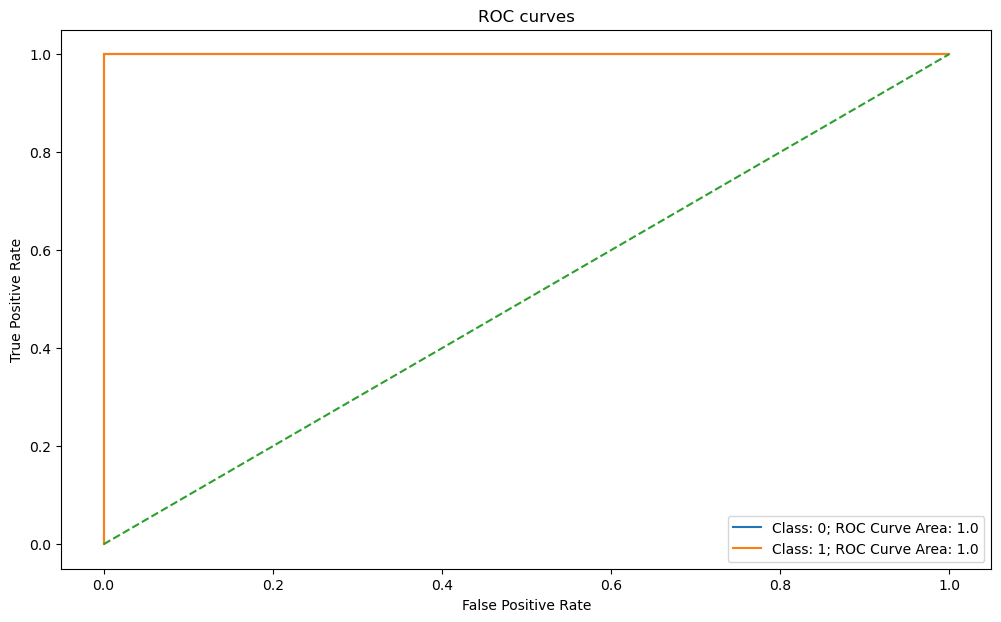

In [27]:
classification_and_roc_calculation(trainX, trainY, selected_features)

### v. Test the classifier on the test set. 

In [28]:
test_set = load_dataset(test_files, selected_features, ORIGINAL_COLUMNS, segs=1)
test_set = convert_text_labels_to_boolean(pd.DataFrame(test_set))
testX, testY = get_data_X_Y(test_set)
testX

mean1  3rd_quartile1   max2   min5   max5  1st_quartile5
0   40.624792        42.0000   1.30  27.25  38.25        33.0000
1   42.812812        43.6700   1.22  27.67  38.50        32.0000
2   34.227771        37.7500  14.50   6.75  26.00        14.7500
3   33.509729        36.7500  13.05   7.25  25.00        14.6275
4   34.660583        38.2500  13.44   7.00  24.50        14.2500
5   24.562958        26.5000   6.87  10.67  30.00        20.5000
6   27.464604        30.0000   7.76   0.00  33.00        15.0000
7   44.334729        46.5000   3.90   0.00  23.00         9.3300
8   43.174938        44.5000   2.12   2.00  21.25        12.7500
9   42.760562        45.3725   3.34   1.33  21.33        13.0000
10  42.363563        43.5000   4.44   1.00  28.00        10.1875
11  45.917667        46.5000   4.87   2.00  24.00        16.5000
12  45.239667        45.3300   1.00   4.75  26.75        17.6275
13  27.716375        29.0000   1.79   0.00  21.00         5.5000
14  44.182937        48.0000   3.11   0.00  12.75         2.0000
15  48.004167        48.0000   0.43   0.00  12.00         4.6700
16  37.177042        40.2500   8.58   7.00  25.50        17.9500
17  37.561187        40.2500   9.91  10.50  24.33        18.0000
18  37.058708        40.0625  14.17   7.50  24.25        16.0000

[[15  0]
 [ 0  4]]


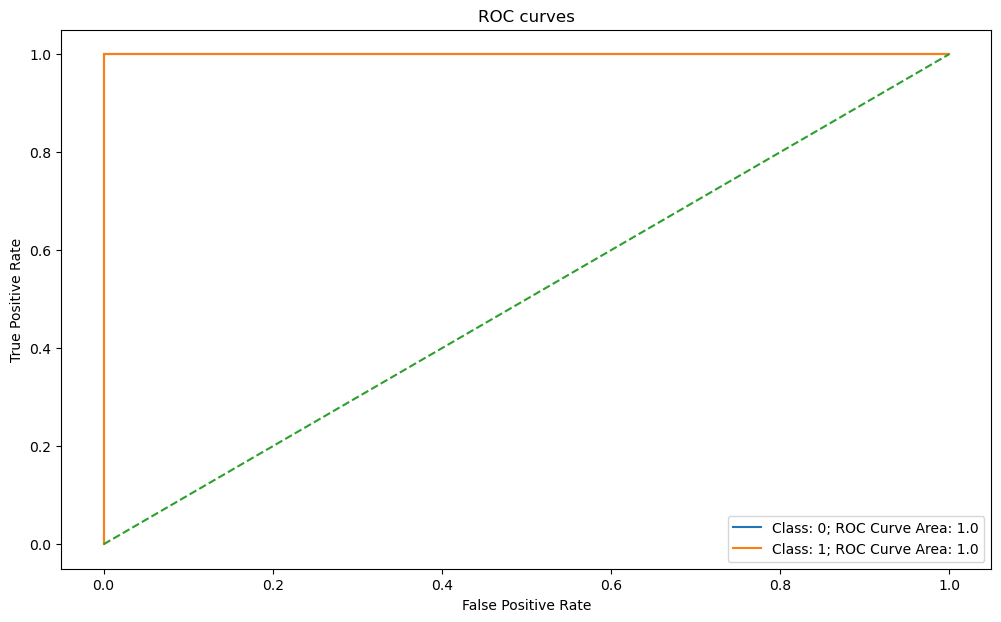

In [29]:
classification_and_roc_calculation(testX, testY, selected_features, isTest=True)

### The accuracy fot the test as well as the cross validation seems to be almost same.

### vi. Do your classes seem to be well-separated to cause instability in calculating logistic regression parameters?

- The p-value analysis using statmodel suggests that there is Complete Separation. It further suggests that the results show that there is complete separation. In this case the Maximum likelihood estimator does not exist and the parameters are not identified.
 
Due to this finding, it is possible that the well-separation of the classes is cauisng the instability in calculation of the regression parameters.

### vii. From the confusion matrices you obtained, do you see imbalanced classes? If yes, build a logistic regression model based on case-control sampling and adjust its parameters. Report the confusion matrix, ROC, and AUC of the model

- According to my assignment; 0 = non-bending classes and 1 = bending classes. I can observe, according to the confusion matrices, that there are 69 instances of non-bending classes and 9 instances for bending classes which goes to show that the classes are definitely imbalanced.

- Since the answer to the above observation is yes, it means that we will have to build a regression model on case-controlled sampling i.e. we will have to oversample.

In [30]:
print("Performing logistic regression with oversampling = True")
cross_validation_factor = 5
L = 20
combination = {
    'l, p': [],
    'score': []
}
for l_val in range(1, L + 1):
    model, selector = logistic_regression(train_files, test_files, l_val, cross_validation_factor, oversample=True)
    nf = selector.n_features_
    score = selector.cv_results_['mean_test_score'].max()
    combination['l, p'].append((l_val, nf))
    combination['score'].append(round(score, 4))

df = pd.DataFrame(combination)
df

Performing logistic regression with oversampling = True
L-value:  1
Performing oversampling of dataset...
L-value:  2
Performing oversampling of dataset...
L-value:  3
Performing oversampling of dataset...
L-value:  4
Performing oversampling of dataset...
L-value:  5
Performing oversampling of dataset...
L-value:  6
Performing oversampling of dataset...
L-value:  7
Performing oversampling of dataset...
L-value:  8
Performing oversampling of dataset...
L-value:  9
Performing oversampling of dataset...
L-value:  10
Performing oversampling of dataset...
L-value:  11
Performing oversampling of dataset...
L-value:  12
Performing oversampling of dataset...
L-value:  13
Performing oversampling of dataset...
L-value:  14
Performing oversampling of dataset...
L-value:  15
Performing oversampling of dataset...
L-value:  16
Performing oversampling of dataset...
L-value:  17
Performing oversampling of dataset...
L-value:  18
Performing oversampling of dataset...
L-value:  19
Performing oversamplin

l, p   score
0    (1, 4)  1.0000
1    (2, 7)  0.9833
2    (3, 3)  1.0000
3    (4, 3)  0.9917
4    (5, 3)  0.9917
5    (6, 3)  0.9917
6    (7, 2)  0.9917
7    (8, 3)  0.9917
8    (9, 9)  1.0000
9   (10, 6)  1.0000
10  (11, 2)  0.9917
11  (12, 8)  1.0000
12  (13, 4)  1.0000
13  (14, 7)  1.0000
14  (15, 9)  1.0000
15  (16, 8)  1.0000
16  (17, 4)  1.0000
17  (18, 3)  1.0000
18  (19, 6)  1.0000
19  (20, 7)  1.0000

In [31]:
l_value = 1
fold_count = 5
features = get_features(ordered_STATS, 6 * l_value + 1)
classifier, selector = logistic_regression(train_files, test_files, l_value, fold_count, oversample=True)
selected_features = get_selected_features(features, selector)
selected_features

L-value:  1
Performing oversampling of dataset...


['3rd_quartile1', 'min5', 'max5', 'mean5']

Performing oversampling of dataset...
[[60  0]
 [ 0 60]]


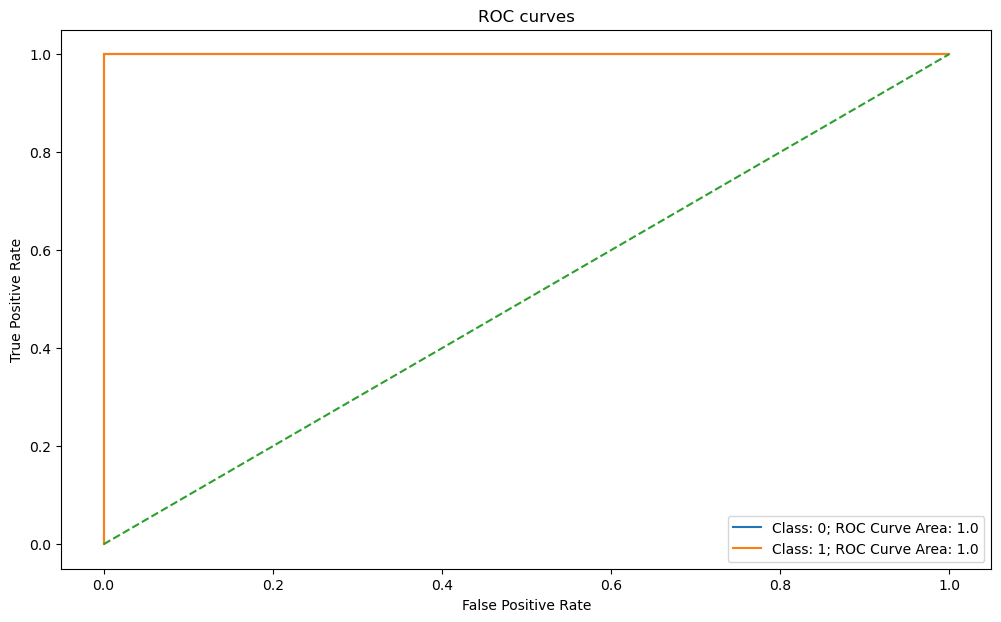

In [32]:
train_set = load_dataset(train_files, selected_features, ORIGINAL_COLUMNS, segs=1)
train_set = convert_text_labels_to_boolean(pd.DataFrame(train_set))
train_set = oversample_data_set(train_set)
trainX, trainY = get_data_X_Y(train_set)
classification_and_roc_calculation(trainX, trainY, selected_features)

[[15  0]
 [ 0  4]]


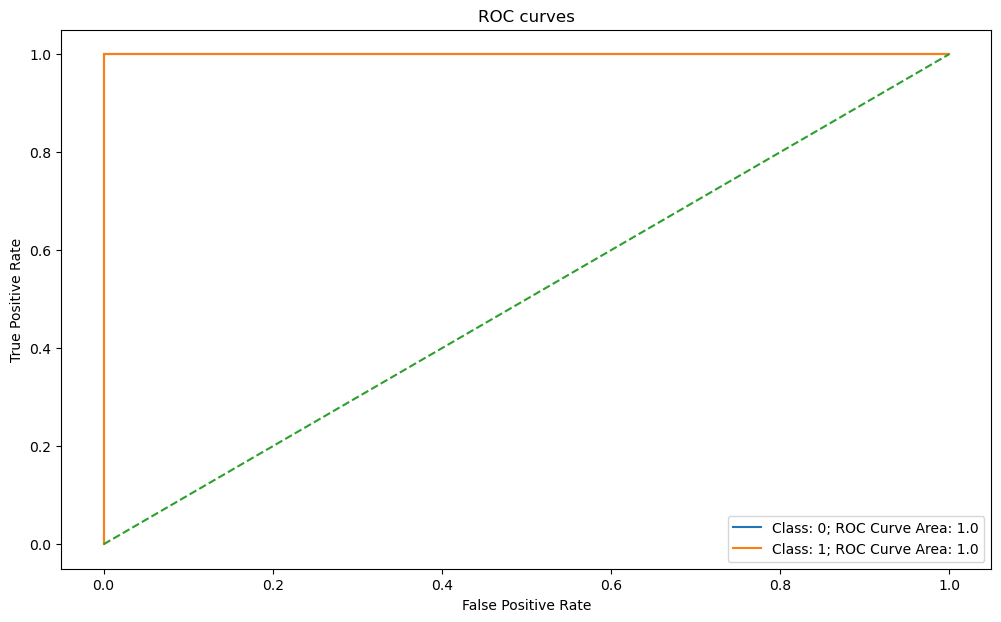

In [33]:
test_set = load_dataset(test_files, selected_features, ORIGINAL_COLUMNS, segs=1)
test_set = convert_text_labels_to_boolean(pd.DataFrame(test_set))
testX, testY = get_data_X_Y(test_set)
classification_and_roc_calculation(testX, testY, selected_features)

## (b) Binary Classification Using L 1 -penalized logistic regression

### i. Repeat 2(a)iii using L1 -penalized logistic regression,8 i.e. instead of using p- values for variable selection, use L 1 regularization.

In [34]:
max_test_accuracy = 0
optimal_L = 1

def perform_regression_with_classifier(classifier, classifier_name, l_val, kwargs, penalty='none', 
                              is_binary_classification=True, draw_roc=False):
    print("L-value " +  str(l_val))
    features = get_features(ordered_STATS, 6 * l_val + 1)
    train_set = load_dataset(train_files, features, ORIGINAL_COLUMNS, segs=l_val)
    test_set = load_dataset(test_files, features, ORIGINAL_COLUMNS, segs=l_val)
    
    if is_binary_classification:
        train_set = get_binary_labelled_dataframe(pd.DataFrame(train_set))
        test_set = get_binary_labelled_dataframe(pd.DataFrame(test_set))
        
    trainX, trainY = get_data_X_Y(train_set)
    testX, testY = get_data_X_Y(test_set)
    
    if is_binary_classification:
        trainY = trainY.astype('int')
        testY = testY.astype('int')
    
    classifier2 = classifier(**kwargs)
    classifier2.fit(trainX, trainY)
    
    if not draw_roc:    
        train_score = round(classifier2.score(trainX, trainY), 4)
        test_score = round(classifier2.score(testX, testY), 4)
        print(f'Value of L: {l_val} | train_score: {train_score} | test_score: {test_score}')
        print(f'Value of L: {l_val} | train_error: {round((1 - train_score), 4)} | test_error: {round((1 - test_score), 4)}\n')
        global max_test_accuracy
        global optimal_L
        if test_score > max_test_accuracy:
            max_test_accuracy = test_score
            optimal_L = l_val
        
        if l_val == 20:
            print('\n')
            print(f'The maximum accuracy is {max_test_accuracy} (for L-value: {optimal_L})')
            print(f'Further calculations will be done with L-value: {optimal_L}')
        
    else:
        train_predictY_prob = classifier2.predict_proba(trainX)
        test_predictY_prob = classifier2.predict_proba(testX)

        predictY = classifier2.predict(testX)
        cm = confusion_matrix(testY, predictY)
        print(f"Confusion matrix for test data:\n{cm}")
        
        print("ROC Curve for Train Data")
        plot_roc_curve(trainY, train_predictY_prob, classifier2)
        
        print("ROC Curve for Test Data")
        plot_roc_curve(testY, test_predictY_prob, classifier2)

In [35]:
kwargs = {
    'penalty' : 'l1', 
    'max_iter' : 100,
    'scoring' : 'accuracy',
    'cv' : 5,
    'random_state' : 69,
    'solver' : 'liblinear'
}

fold_count = 5

for l_val in range(1, 21):
    perform_regression_with_classifier(LogisticRegressionCV,
                                       "Logistic Regression", 
                                       l_val, 
                                       kwargs, 
                                       penalty='none',
                                       is_binary_classification=True, 
                                       draw_roc=False)

L-value 1
Value of L: 1 | train_score: 1.0 | test_score: 1.0
Value of L: 1 | train_error: 0.0 | test_error: 0.0

L-value 2
Value of L: 2 | train_score: 0.9565 | test_score: 0.9474
Value of L: 2 | train_error: 0.0435 | test_error: 0.0526

L-value 3
Value of L: 3 | train_score: 1.0 | test_score: 1.0
Value of L: 3 | train_error: 0.0 | test_error: 0.0

L-value 4
Value of L: 4 | train_score: 1.0 | test_score: 0.9474
Value of L: 4 | train_error: 0.0 | test_error: 0.0526

L-value 5
Value of L: 5 | train_score: 1.0 | test_score: 0.9474
Value of L: 5 | train_error: 0.0 | test_error: 0.0526

L-value 6
Value of L: 6 | train_score: 1.0 | test_score: 0.9474
Value of L: 6 | train_error: 0.0 | test_error: 0.0526

L-value 7
Value of L: 7 | train_score: 1.0 | test_score: 1.0
Value of L: 7 | train_error: 0.0 | test_error: 0.0

L-value 8
Value of L: 8 | train_score: 1.0 | test_score: 0.9474
Value of L: 8 | train_error: 0.0 | test_error: 0.0526

L-value 9
Value of L: 9 | train_score: 1.0 | test_score: 0.9

L-value 1
Confusion matrix for test data:
[[15  0]
 [ 0  4]]
ROC Curve for Train Data


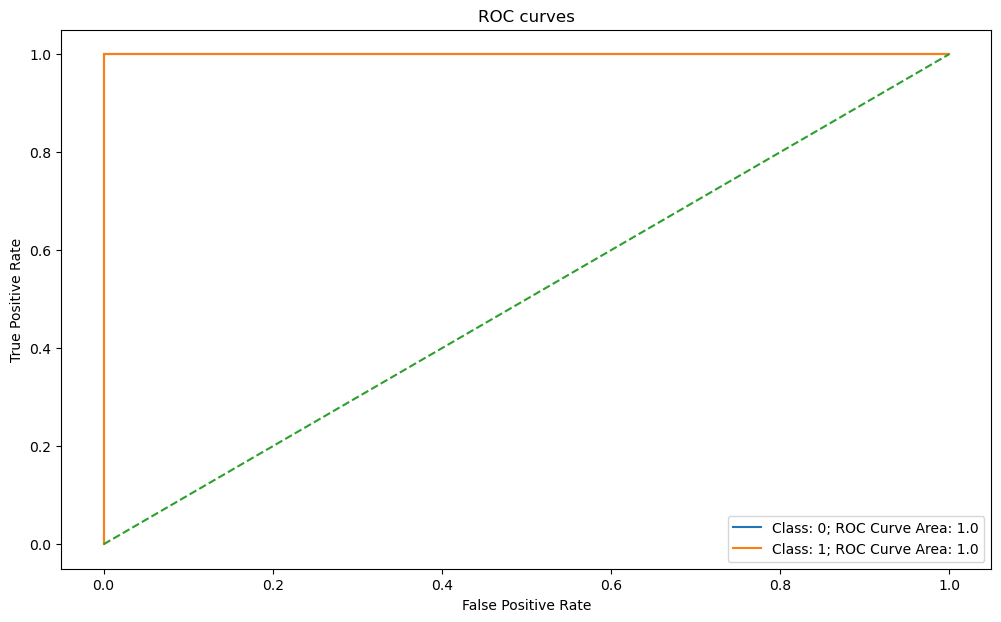

ROC Curve for Test Data


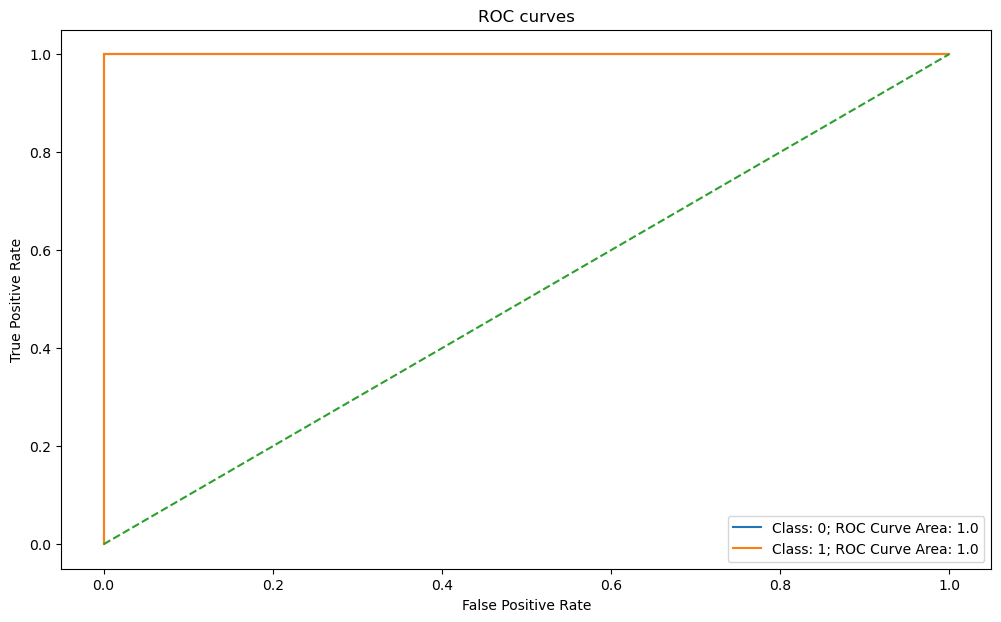

In [36]:
# making use of the varargs concept
kwargs = {
    'penalty' : 'l1', 
    'max_iter' : 100, 
    'solver' : 'liblinear'
}

fold_count = 5
best_l = 1

# performing regression with the given classifier for the best value of L calculated from the above cell
perform_regression_with_classifier(LogisticRegression,
                                   "Logistic Regression",
                                   best_l, 
                                   kwargs, 
                                   penalty='none',
                                   is_binary_classification=True, 
                                   draw_roc=True)

### ii. Compare the L 1 -penalized with variable selection using p-values. Which one performs better? Which one is easier to implement?

The L1-penalized logistic regression has better performance in terms of accuracy when tested on the test data (approximately ~ 1.0) and hence, <b>the L1-penalized performs better.
The L1-regularization is easier to implement as feature selection does not need to be manual.</b>

## (c) Multi-class Classification (The Realistic Case)

### i. Find the best l in the same way as you found it in 2(b)i to build an L 1 - penalized multinomial regression model to classify all activities in your training set.


In [37]:
kwargs = {
    'penalty' : 'l1', 
    'max_iter' : 100,
    'multi_class': 'multinomial',
    'cv': 5,
    'random_state' : 69,
    'solver' : 'saga'
}

fold_count = 5
global max_test_accuracy
max_test_accuracy = 0

global optimal_L
optimal_L = 1

for l_val in range(1, 21):
    perform_regression_with_classifier(LogisticRegressionCV, 
                                       "Logistic Regression",
                                       l_val, 
                                       kwargs, 
                                       penalty='none',
                                       is_binary_classification=False, 
                                       draw_roc=False)

L-value 1
Value of L: 1 | train_score: 1.0 | test_score: 0.8947
Value of L: 1 | train_error: 0.0 | test_error: 0.1053

L-value 2
Value of L: 2 | train_score: 1.0 | test_score: 0.9474
Value of L: 2 | train_error: 0.0 | test_error: 0.0526

L-value 3
Value of L: 3 | train_score: 1.0 | test_score: 0.8421
Value of L: 3 | train_error: 0.0 | test_error: 0.1579

L-value 4
Value of L: 4 | train_score: 1.0 | test_score: 0.8947
Value of L: 4 | train_error: 0.0 | test_error: 0.1053

L-value 5
Value of L: 5 | train_score: 1.0 | test_score: 0.8421
Value of L: 5 | train_error: 0.0 | test_error: 0.1579

L-value 6
Value of L: 6 | train_score: 1.0 | test_score: 0.7895
Value of L: 6 | train_error: 0.0 | test_error: 0.2105

L-value 7
Value of L: 7 | train_score: 1.0 | test_score: 0.7368
Value of L: 7 | train_error: 0.0 | test_error: 0.2632

L-value 8
Value of L: 8 | train_score: 1.0 | test_score: 0.7895
Value of L: 8 | train_error: 0.0 | test_error: 0.2105

L-value 9
Value of L: 9 | train_score: 0.9855 | 

L-value 2
Confusion matrix for test data:
[[2 0 0 0 0 0 0]
 [0 1 1 0 0 0 0]
 [0 0 3 0 0 0 0]
 [0 0 0 3 0 0 0]
 [0 0 0 0 2 1 0]
 [0 0 0 0 0 3 0]
 [0 0 0 0 0 0 3]]
ROC Curve for Train Data


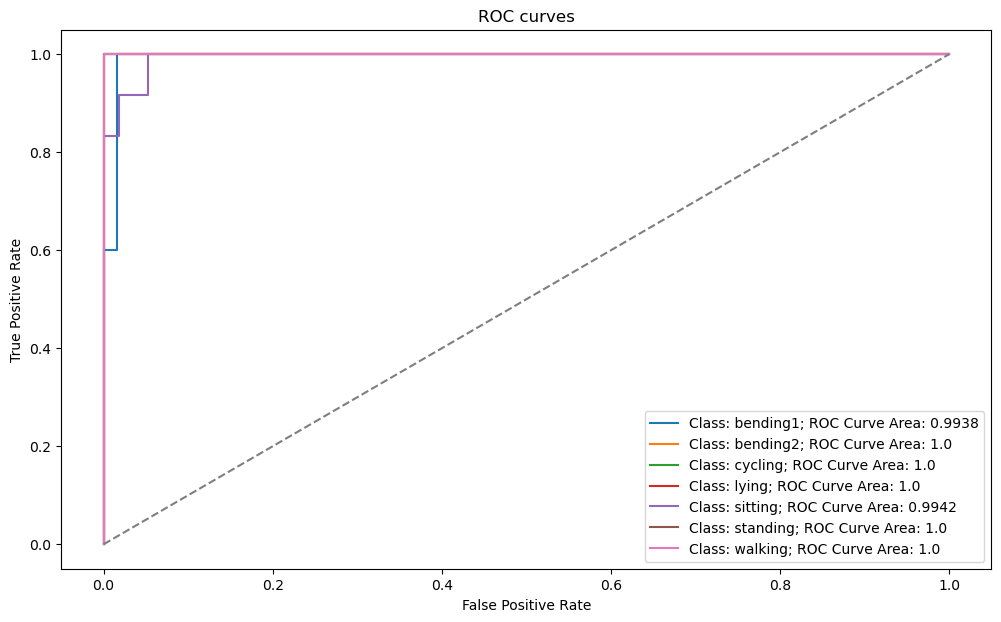

ROC Curve for Test Data


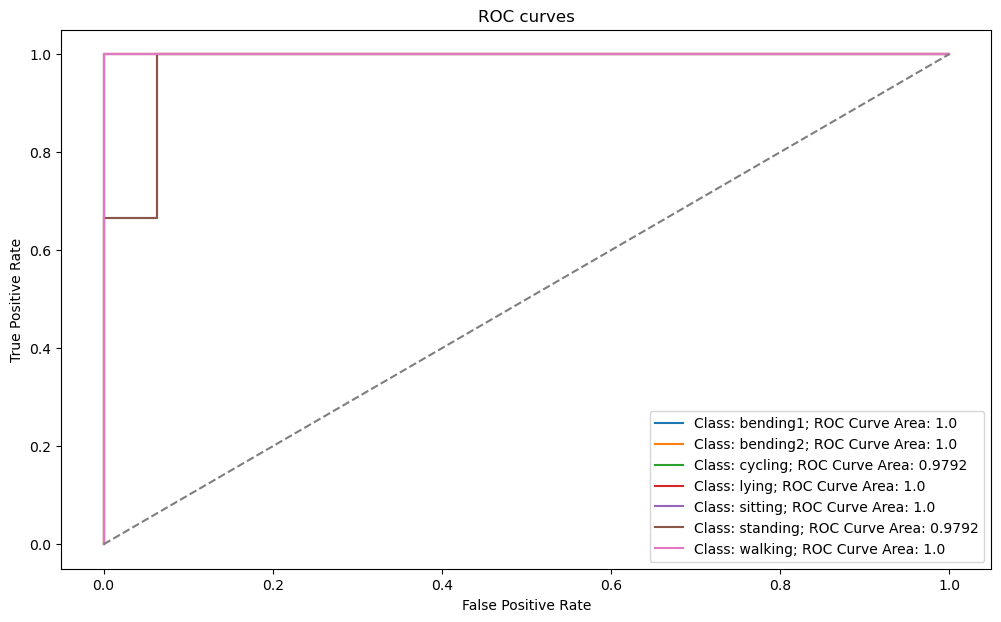

In [38]:
kwargs = {
    'penalty' : 'l1', 
    'max_iter' : 100, 
    'multi_class' : 'multinomial',
    'solver' : 'saga'
}

fold_count = 5
best_l = optimal_L

perform_regression_with_classifier(LogisticRegression, 
                                   "Logistic Regression",
                                   best_l, 
                                   kwargs, 
                                   penalty='none',
                                   is_binary_classification=False, 
                                   draw_roc=True)

### ii. Repeat 2(c)i using a Na ̈ıve Bayes’ classifier. Use both Gaussian and Multi-nomial priors and compare the results.

In [39]:
kwargs = {
    
}

fold_count = 5
global max_test_accuracy
max_test_accuracy = 0

global optimal_L
optimal_L = 1

for l_val in range(1, 21):
    perform_regression_with_classifier(GaussianNB, 
                                       "Naive Bayes Classifier with Gaussian Prior",
                                       l_val, 
                                       kwargs, 
                                       penalty='none',
                                       is_binary_classification=False, 
                                       draw_roc=False)

L-value 1
Value of L: 1 | train_score: 1.0 | test_score: 0.8947
Value of L: 1 | train_error: 0.0 | test_error: 0.1053

L-value 2
Value of L: 2 | train_score: 1.0 | test_score: 0.6316
Value of L: 2 | train_error: 0.0 | test_error: 0.3684

L-value 3
Value of L: 3 | train_score: 0.9855 | test_score: 0.7368
Value of L: 3 | train_error: 0.0145 | test_error: 0.2632

L-value 4
Value of L: 4 | train_score: 1.0 | test_score: 0.7895
Value of L: 4 | train_error: 0.0 | test_error: 0.2105

L-value 5
Value of L: 5 | train_score: 0.9855 | test_score: 0.7895
Value of L: 5 | train_error: 0.0145 | test_error: 0.2105

L-value 6
Value of L: 6 | train_score: 0.971 | test_score: 0.6316
Value of L: 6 | train_error: 0.029 | test_error: 0.3684

L-value 7
Value of L: 7 | train_score: 1.0 | test_score: 0.7368
Value of L: 7 | train_error: 0.0 | test_error: 0.2632

L-value 8
Value of L: 8 | train_score: 0.9855 | test_score: 0.7368
Value of L: 8 | train_error: 0.0145 | test_error: 0.2632

L-value 9
Value of L: 9 | 

L-value 1
Confusion matrix for test data:
[[2 0 0 0 0 0 0]
 [0 2 0 0 0 0 0]
 [0 0 3 0 0 0 0]
 [0 0 0 2 1 0 0]
 [0 0 0 0 3 0 0]
 [0 0 0 0 1 2 0]
 [0 0 0 0 0 0 3]]
ROC Curve for Train Data


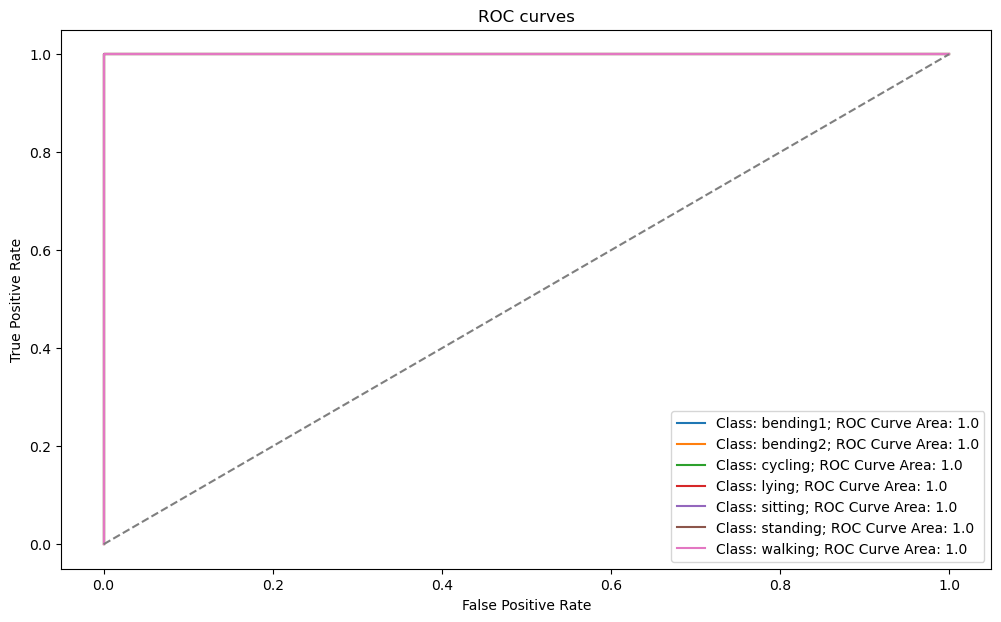

ROC Curve for Test Data


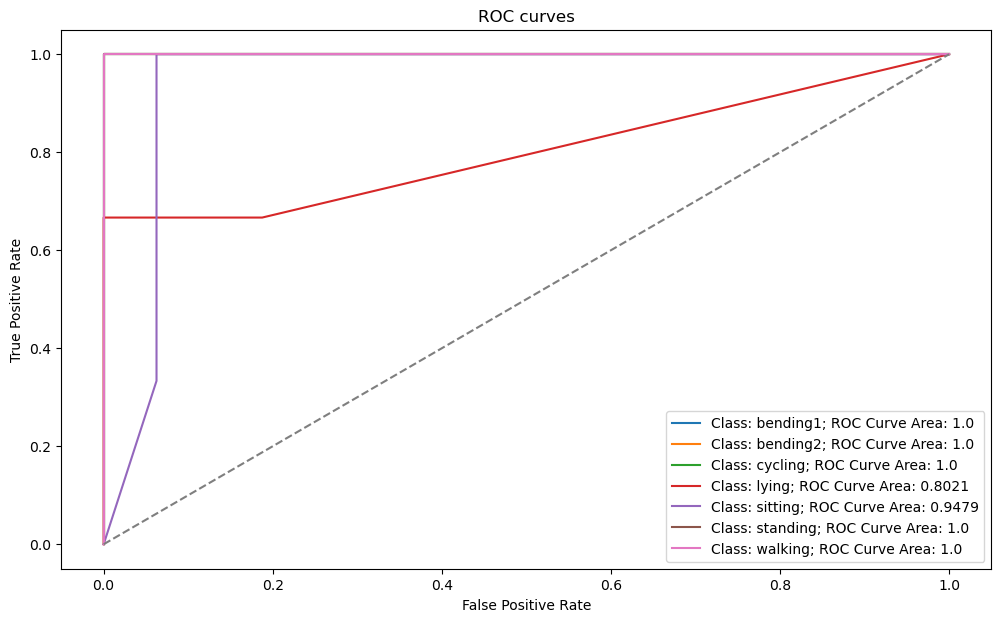

In [40]:
kwargs = {
    
}

fold_count = 5
best_l = optimal_L

perform_regression_with_classifier(GaussianNB, 
                                   "Naive Bayes Classifier with Gaussian Prior",
                                   best_l, 
                                   kwargs, 
                                   penalty='none',
                                   is_binary_classification=False, 
                                   draw_roc=True)

In [41]:
kwargs = {
    
}

fold_count = 5
global max_test_accuracy
max_test_accuracy = 0

global optimal_L
optimal_L = 1

for l_val in range(1, 21):
    perform_regression_with_classifier(MultinomialNB, 
                                       "Naive Bayes Classifier with Multinomial Prior",
                                       l_val, 
                                       kwargs, 
                                       penalty='none',
                                       is_binary_classification=False, 
                                       draw_roc=False)

L-value 1
Value of L: 1 | train_score: 0.9275 | test_score: 0.8947
Value of L: 1 | train_error: 0.0725 | test_error: 0.1053

L-value 2
Value of L: 2 | train_score: 0.8841 | test_score: 0.7368
Value of L: 2 | train_error: 0.1159 | test_error: 0.2632

L-value 3
Value of L: 3 | train_score: 0.8986 | test_score: 0.7895
Value of L: 3 | train_error: 0.1014 | test_error: 0.2105

L-value 4
Value of L: 4 | train_score: 0.913 | test_score: 0.7895
Value of L: 4 | train_error: 0.087 | test_error: 0.2105

L-value 5
Value of L: 5 | train_score: 0.9275 | test_score: 0.7368
Value of L: 5 | train_error: 0.0725 | test_error: 0.2632

L-value 6
Value of L: 6 | train_score: 0.9565 | test_score: 0.7368
Value of L: 6 | train_error: 0.0435 | test_error: 0.2632

L-value 7
Value of L: 7 | train_score: 0.942 | test_score: 0.7368
Value of L: 7 | train_error: 0.058 | test_error: 0.2632

L-value 8
Value of L: 8 | train_score: 0.942 | test_score: 0.7368
Value of L: 8 | train_error: 0.058 | test_error: 0.2632

L-valu

L-value 1
Confusion matrix for test data:
[[2 0 0 0 0 0 0]
 [0 2 0 0 0 0 0]
 [0 0 3 0 0 0 0]
 [0 0 0 3 0 0 0]
 [0 0 0 0 2 1 0]
 [0 0 0 1 0 2 0]
 [0 0 0 0 0 0 3]]
ROC Curve for Train Data


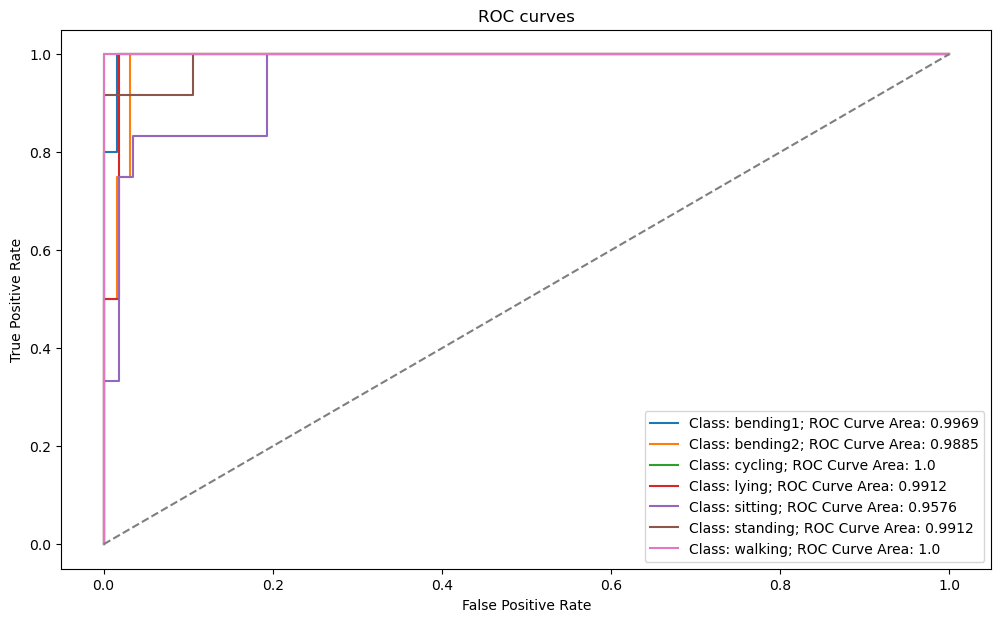

ROC Curve for Test Data


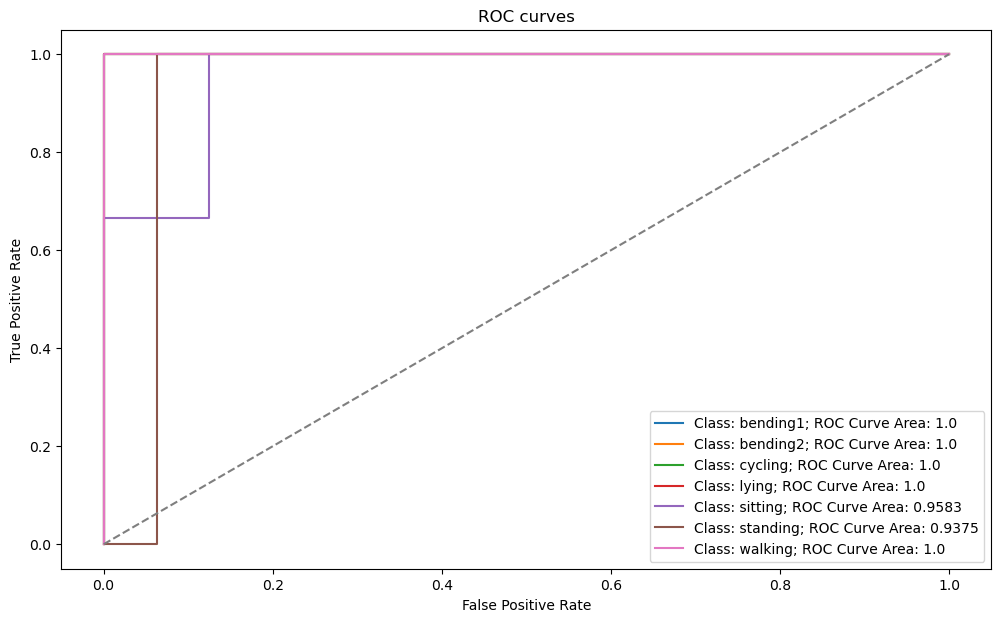

In [42]:
kwargs = {
    
}

fold_count = 5
best_l = optimal_L

perform_regression_with_classifier(MultinomialNB, 
                                   "Naive Bayes Classifier with Multinomial Prior",
                                   best_l, 
                                   kwargs, 
                                   penalty='none',
                                   is_binary_classification=False, 
                                   draw_roc=True)

### iii. Which method is better for multi-class classification in this problem?

<b>The area under the ROC curve (AUC) is relatively better for the Logistic Regression curve than any other classifer prior (Gaussian or Multinomial) and hence, I would say that Logistic Regression has better classification for the given dataset</b>

## 3. ISLR 4.8.3

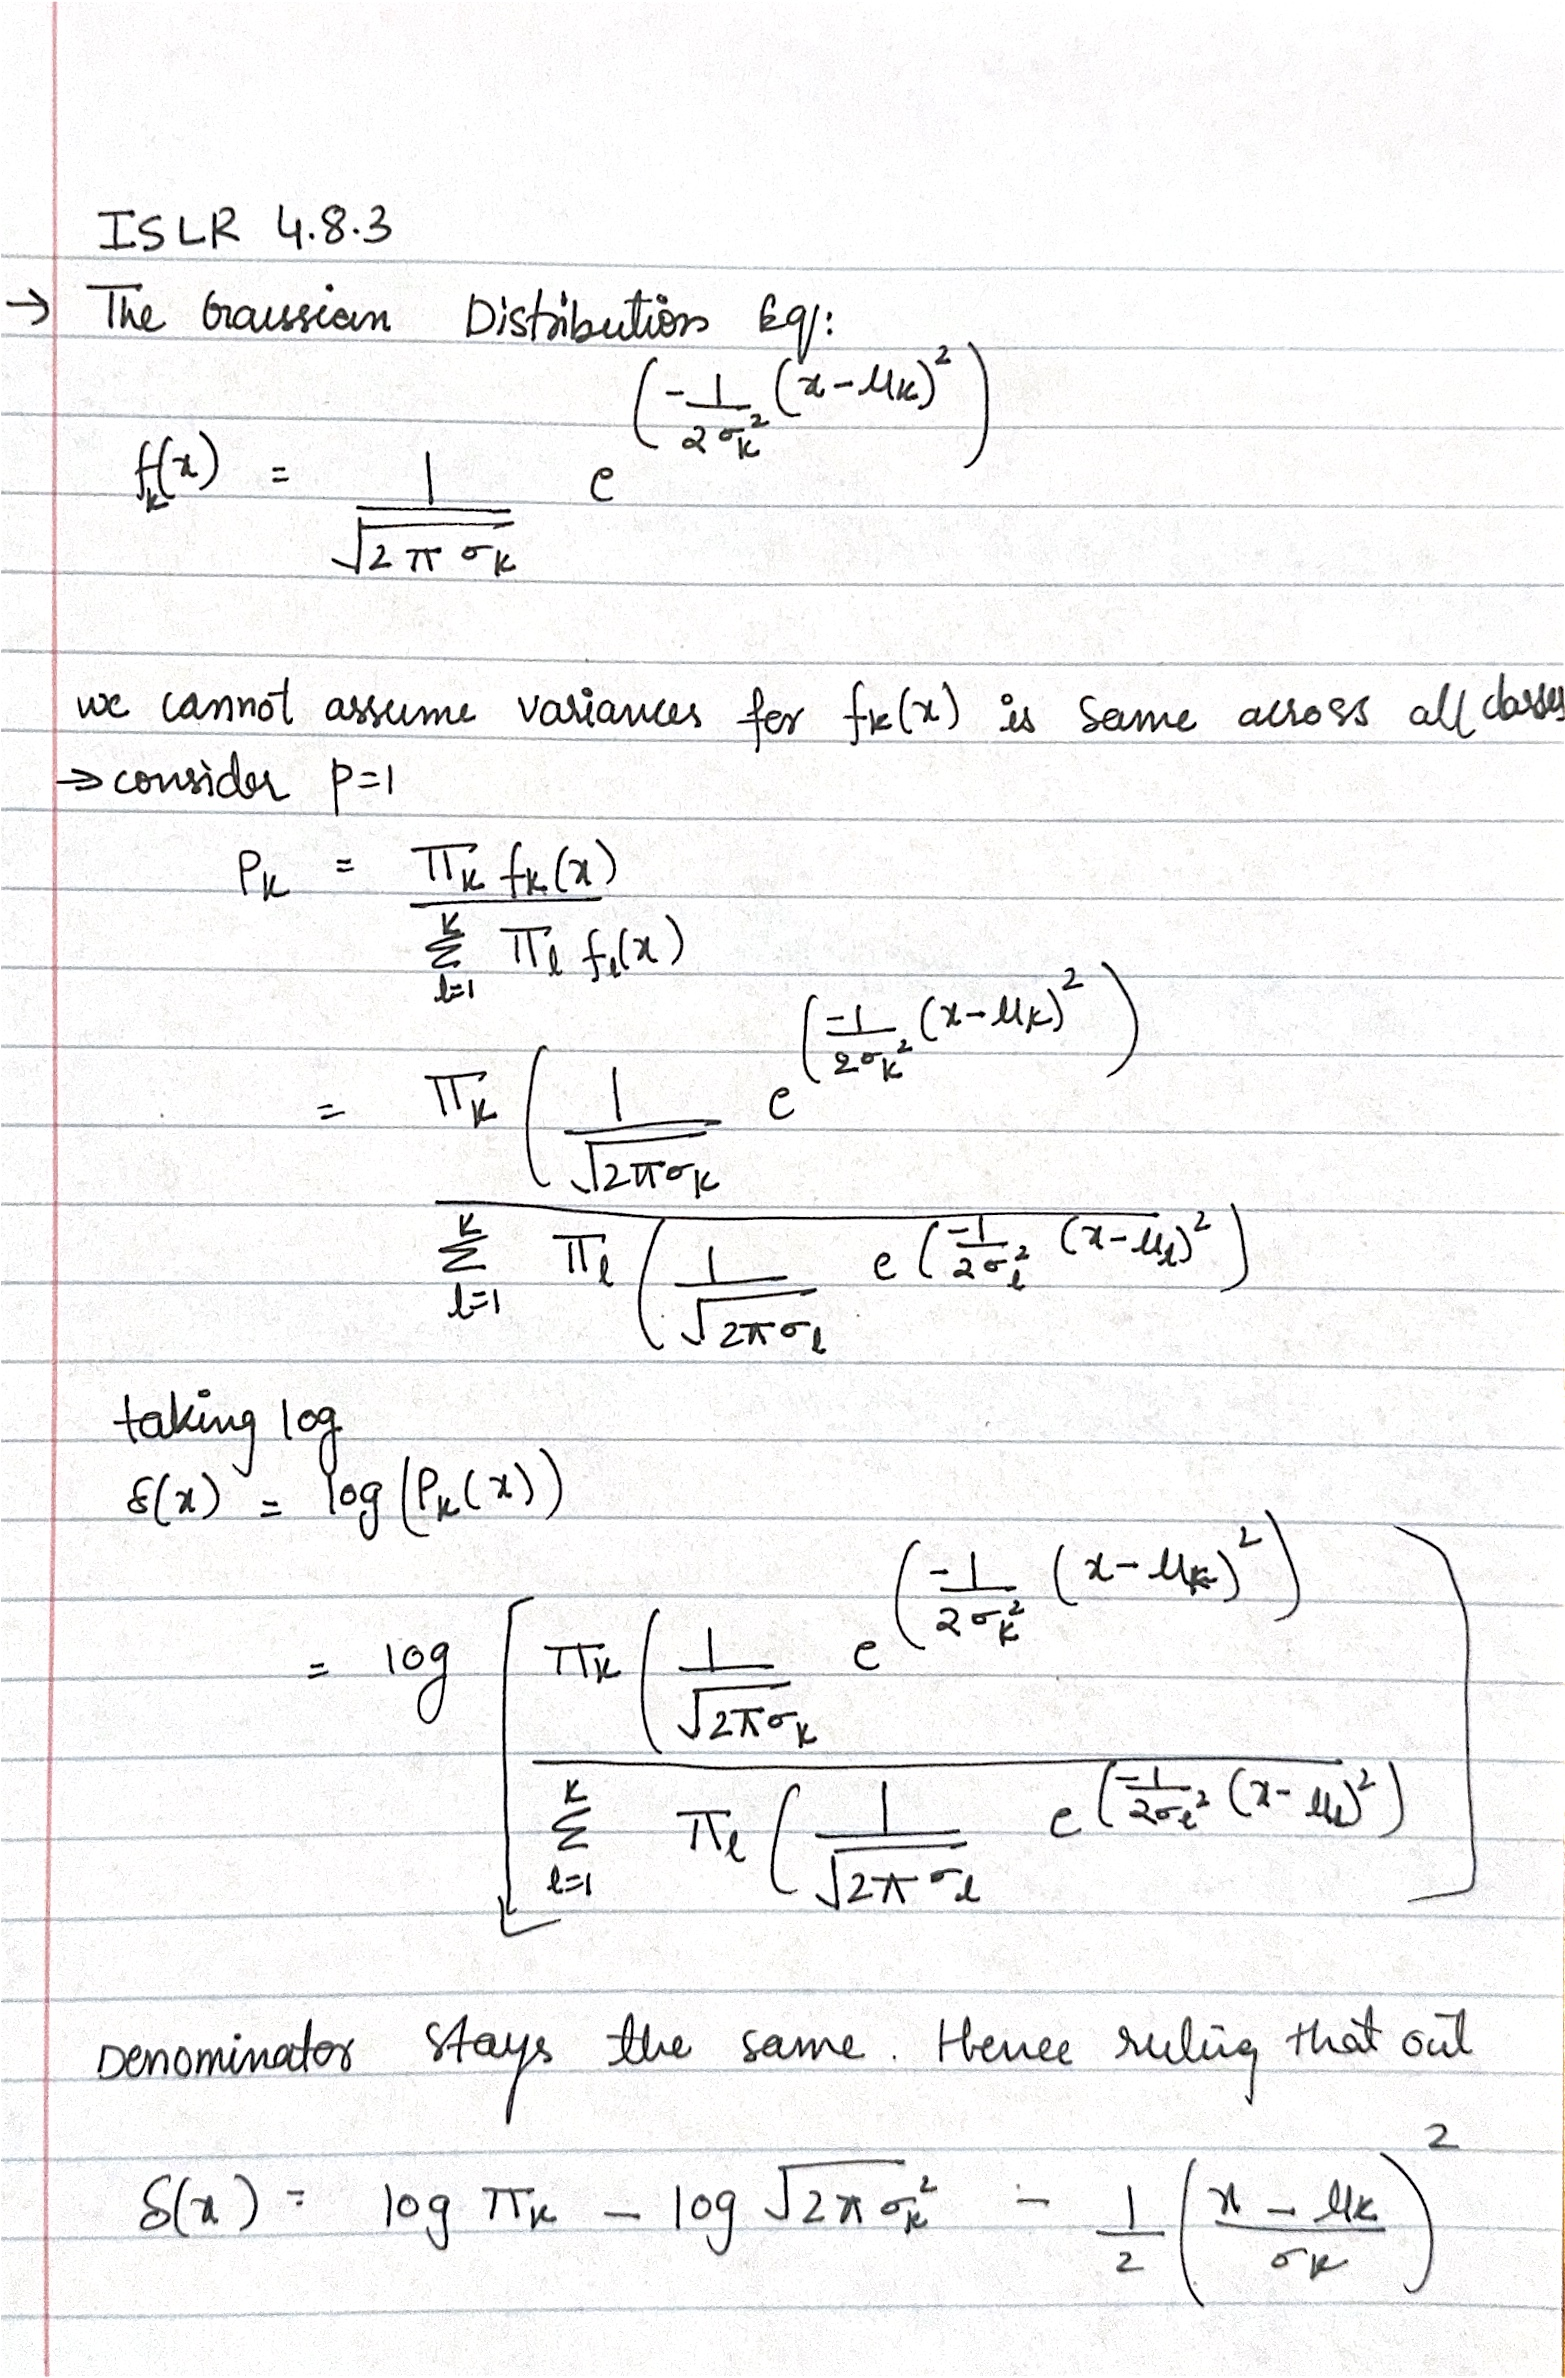

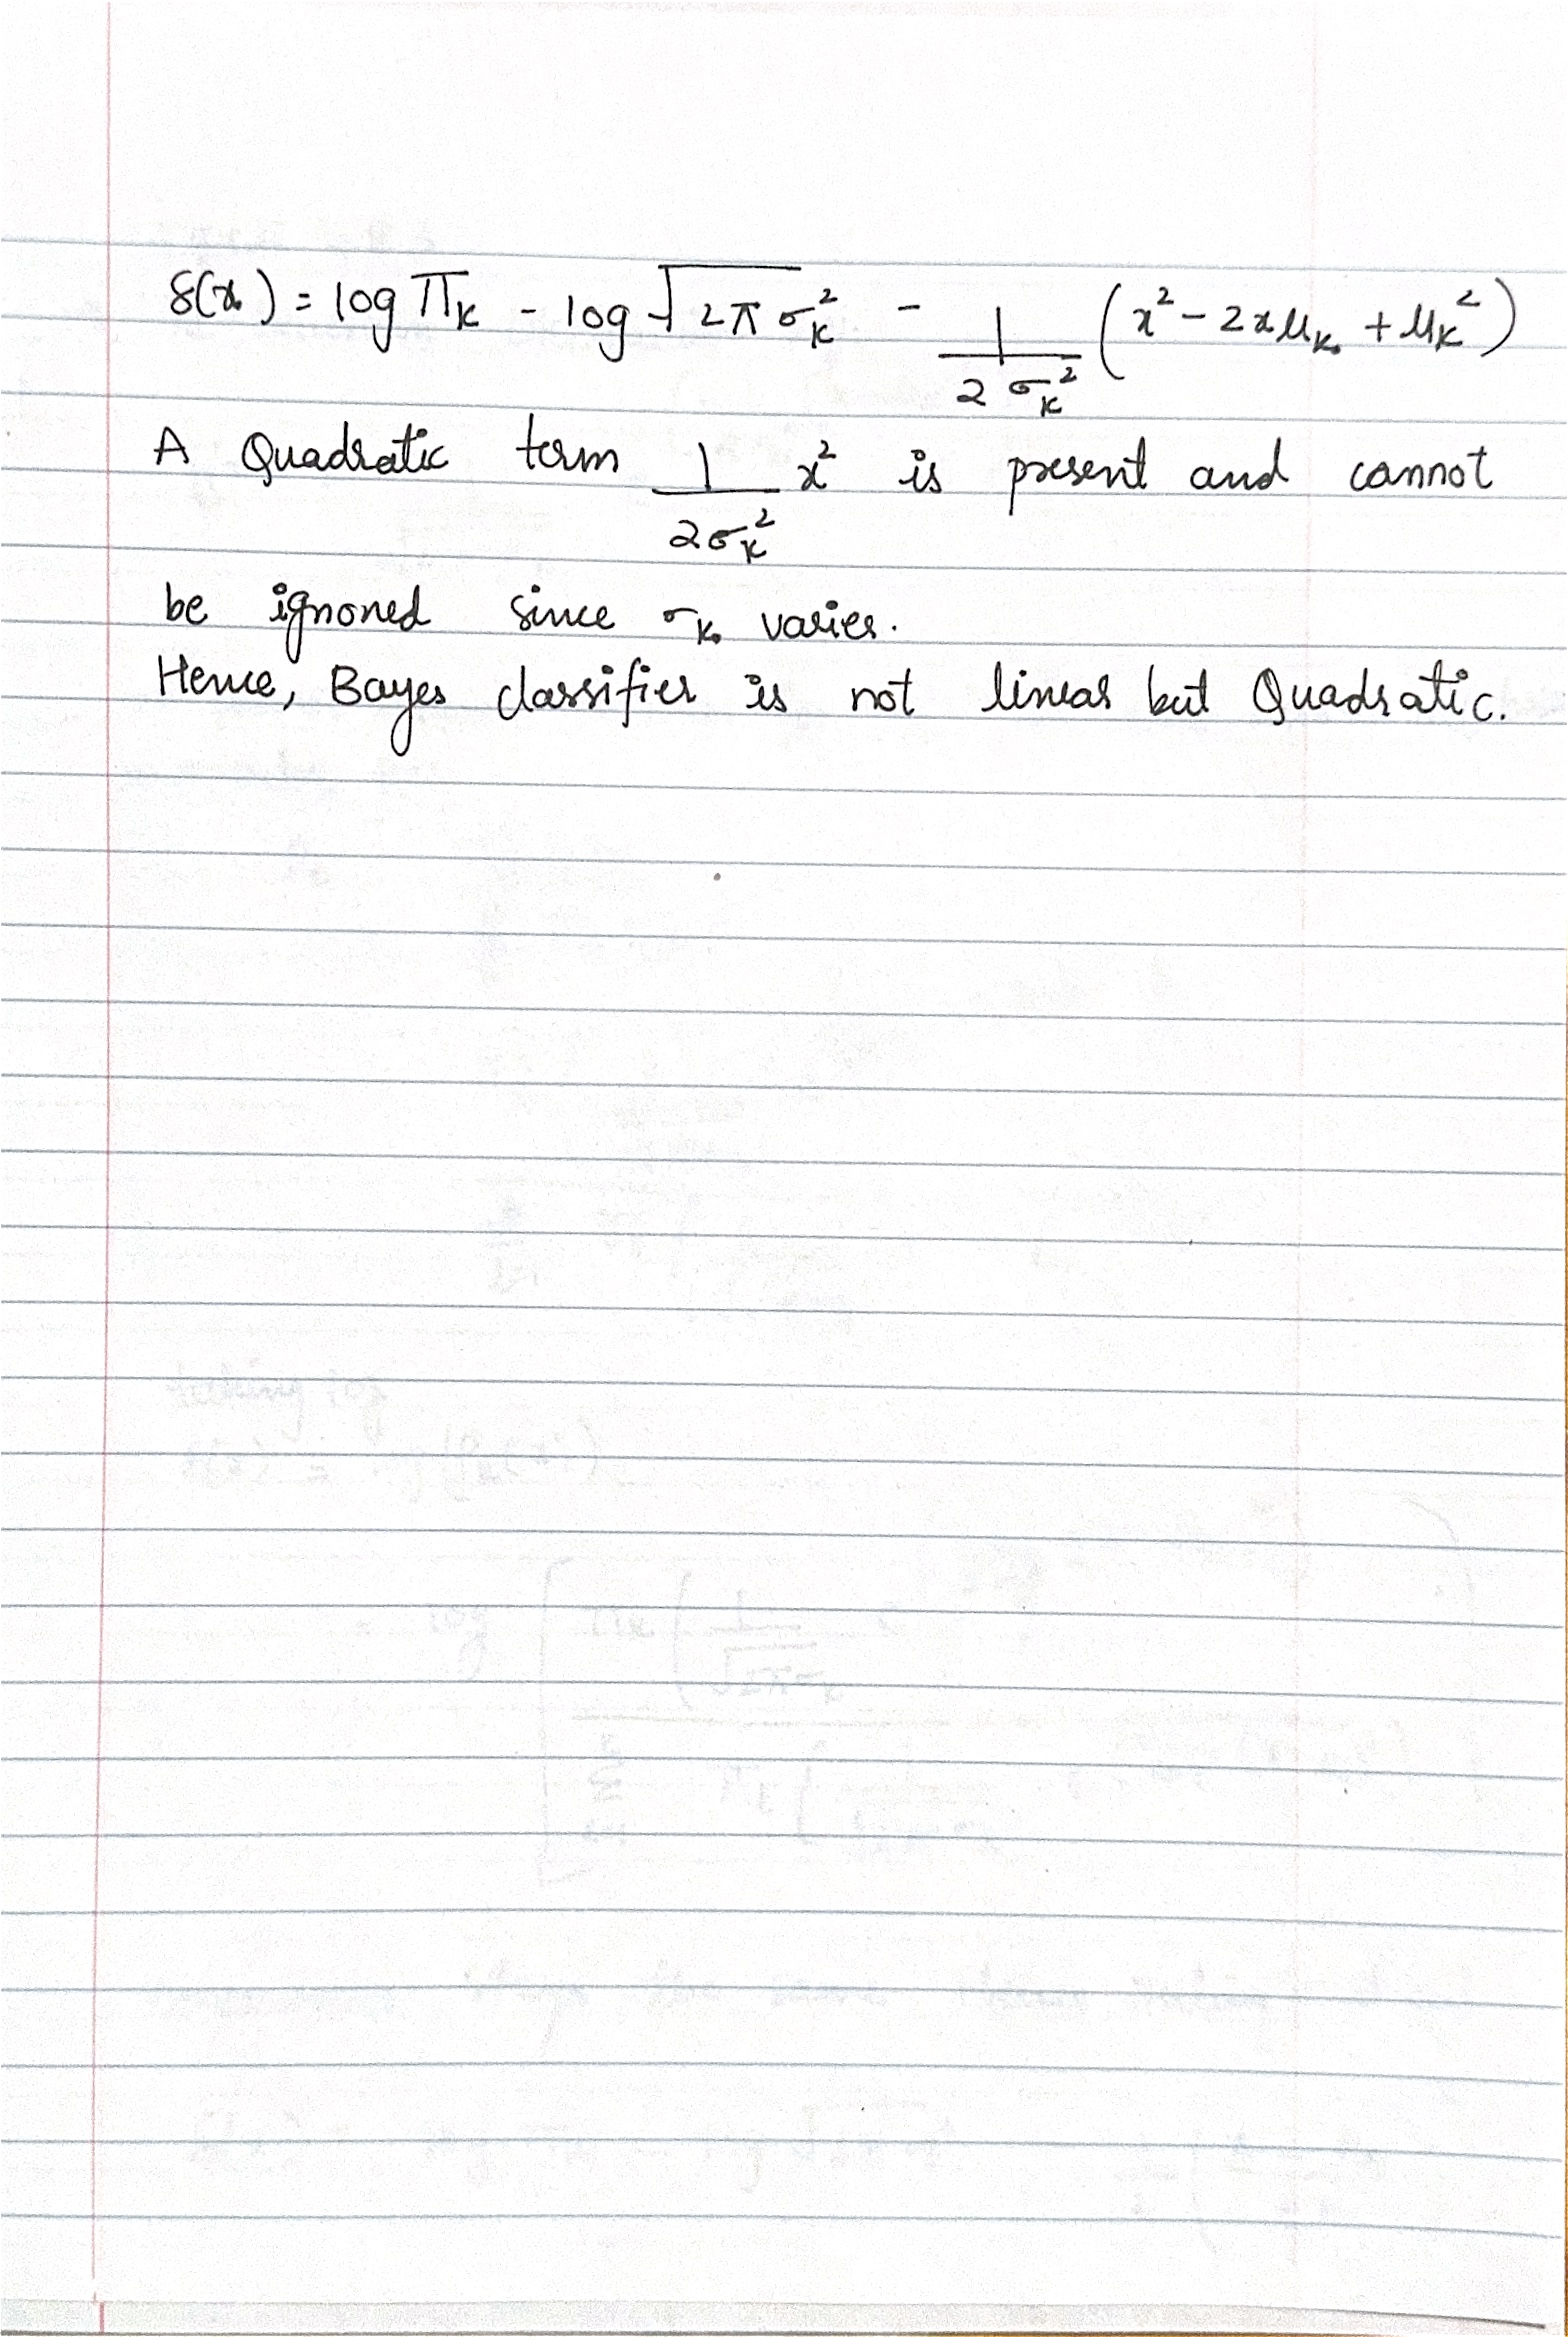

## 4. ISLR 4.8.7

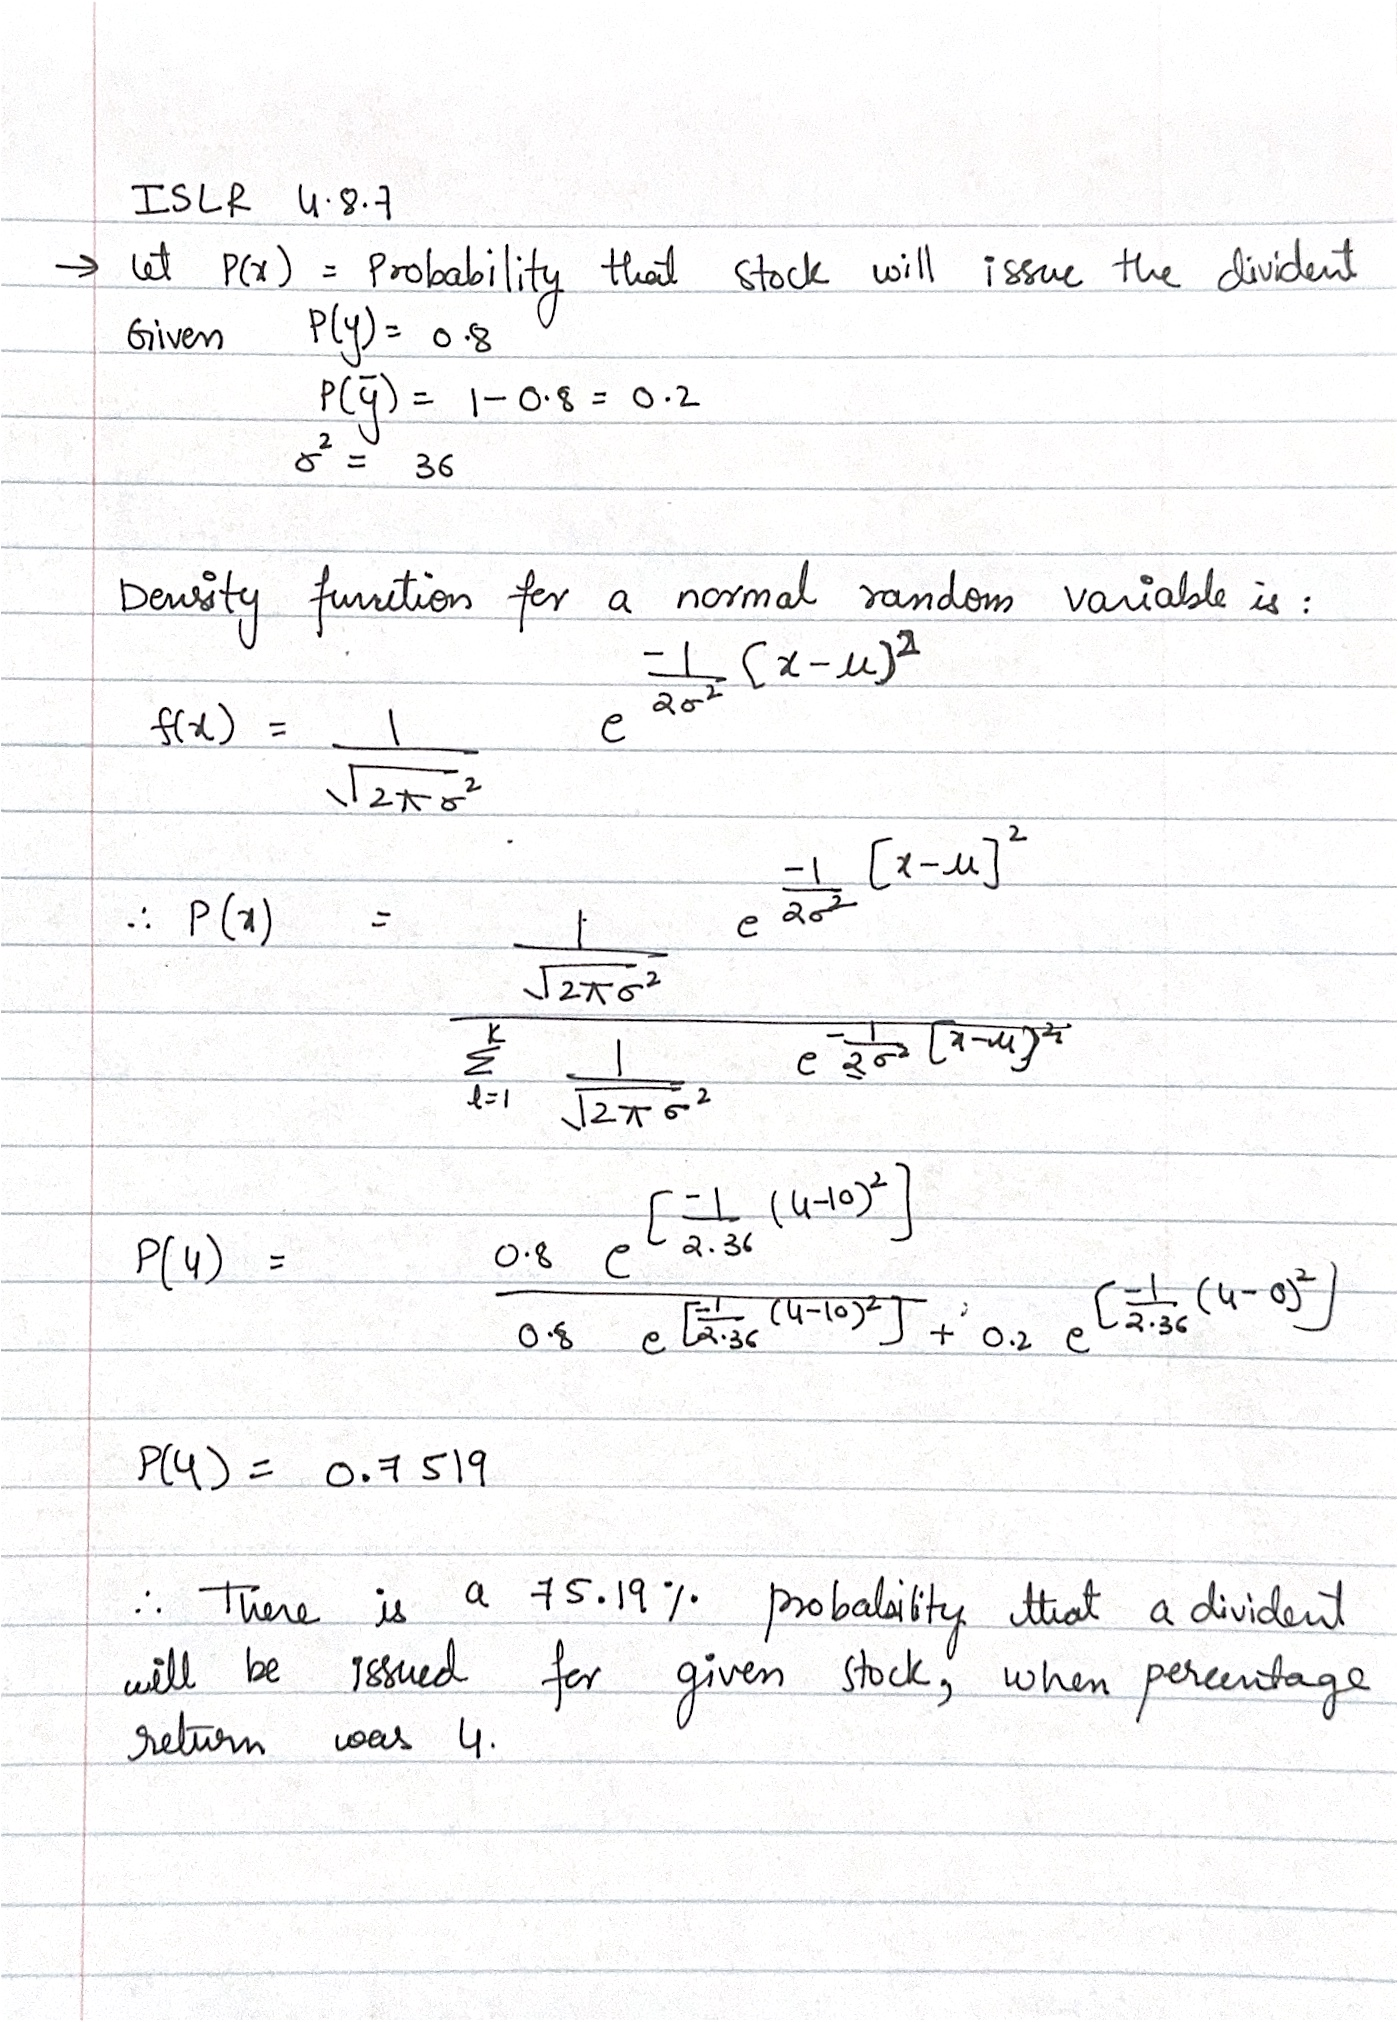